This notebook is used to study model performance on the stability datasets from Rocklin et al. (2017) https://www.science.org/doi/10.1126/science.aan0693 

In [1]:
import Bio.PDB
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
from scipy.stats import ttest_rel


In [2]:
myAmino = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
FullAmino = ['ALA', 'CYS', 'ASP', 'GLU', 'PHE', 'GLY', 'HIS', 'ILE', 'LYS', 'LEU', 'MET', 'ASN', 'PRO', 'GLN', 'ARG', 'SER', 'THR', 'VAL', 'TRP', 'TYR']
aminos = {FullAmino[i]:myAmino[i] for i in range(len(myAmino))}

# zero is used as padding
AA_to_int = {'A': 1,'ALA': 1,'C': 2,'CYS': 2,'D': 3,'ASP': 3,'E': 4,'GLU': 4,'F': 5,'PHE': 5,'G': 6,'GLY': 6,'H': 7,'HIS': 7,'I': 8,'ILE': 8,'K': 9,'LYS': 9,'L': 10,'LEU': 10,'M': 11,'MET': 11,'N': 12,'ASN': 12,'P': 13,'PRO': 13,'Q': 14,'GLN': 14,'R': 15,'ARG': 15,'S': 16,'SER': 16,'T': 17,'THR': 17,'V': 18,
'VAL': 18,'W': 19,'TRP': 19,'Y': 20,'TYR': 20,'X': 21}
## amino acid to integer
atoi = {key: val - 1 for key, val in AA_to_int.items()}
## integer to amino acid
iota = {y: x for x, y in atoi.items() if len(x) == 1}

## Generate average structure for hYAP65

In [4]:
parser = Bio.PDB.PDBParser(QUIET=True)  # Don't show me warnings
structure = parser.get_structure('hYAP65', '../../rocklin_pdbs/hYAP65.pdb')  # id of pdb file and location

In [13]:
# hYAP65 has multiple conformations, so we generate the average structure to allow for input to the model
# as per https://stackoverflow.com/questions/49356018/how-to-calculate-the-average-structure-of-a-protein-with-multiple-models-conform

atoms = [a.parent.parent.id + '-' + str(a.parent.id[1]) + '-' +  a.name for a in structure[0].get_atoms() if a.parent.id[0] == ' ']  # obtained from model '0'

In [14]:
atom_avgs = {}
for atom in atoms:
    atom_avgs[atom] = []
    for model in structure:
        atom_ = atom.split('-')
        coor = model[atom_[0]][int(atom_[1])][atom_[2]].coord
        atom_avgs[atom].append(coor)
    atom_avgs[atom] = sum(atom_avgs[atom]) / len(atom_avgs[atom])  # average

In [15]:
ns = Bio.PDB.StructureBuilder.Structure('id=hYAP65')  #  new structure
ns.add(structure[0])  # add model 0
for atom in ns[0].get_atoms():
    chain = atom.parent.parent
    res = atom.parent
    if res.id[0] != ' ':
        chain.detach_child(res)  # detach hetres
    else:
        coor = atom_avgs[chain.id + '-' + str(res.id[1]) + '-' + atom.name]
        atom.coord = coor

In [16]:
io = Bio.PDB.PDBIO()
io.set_structure(ns)
io.save('new_hYAP65.pdb')

## Extract stability data from the Rocklin dataset

In [5]:
stability_scores = pd.read_csv("../../rocklin/ssm2_stability_scores", delimiter='\t')

In [24]:
stability_scores.keys()

Index(['name', 'sequence', 'my_wt', 'pos', 'mut', 'wt_aa', 'ec50_t',
       'delta_ec50_t', 'ec50_95ci_lbound_t', 'ec50_95ci_ubound_t',
       'ec50_95ci_t', 'ec50_pred_t', 'delta_pred_vs_wt_t', 'ec50_rise_t',
       'stabilityscore_t', 'ec50_c', 'delta_ec50_c', 'ec50_95ci_lbound_c',
       'ec50_95ci_ubound_c', 'ec50_95ci_c', 'ec50_pred_c',
       'delta_pred_vs_wt_c', 'ec50_rise_c', 'stabilityscore_c',
       'ec50_rise_c_adj', 'stabilityscore_c_adj', 'consensus_ec50_rise',
       'consensus_stability_score'],
      dtype='object')

In [4]:
structures = set(stability_scores['my_wt'])

In [5]:
designed_structures = ['EEHEE_rd3_0037.pdb', 'EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1716.pdb', 'EHEE_0882.pdb', 'EHEE_rd2_0005.pdb', 'EHEE_rd3_0015.pdb', 'HEEH_rd2_0779.pdb', 'HEEH_rd3_0223.pdb', 'HEEH_rd3_0726.pdb', 'HEEH_rd3_0872.pdb', 'HHH_0142.pdb', 'HHH_rd2_0134.pdb', 'HHH_rd3_0138.pdb']

In [6]:
real_structures = ['Pin1', 'hYAP65', 'villin']

In [30]:
stability_scores[stability_scores['my_wt'] == "Pin1"]

,name,sequence,my_wt,pos,mut,wt_aa,ec50_t,delta_ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,...,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,delta_pred_vs_wt_c,ec50_rise_c,stabilityscore_c,ec50_rise_c_adj,stabilityscore_c_adj,consensus_ec50_rise,consensus_stability_score
10688,Pin1,GMADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGGSS,Pin1,0,na,wt,4.64,0.00,4.6,4.6,...,2.8,0.0,-1.07,0.00,3.89,1.17,3.89,1.17,4.72,1.42
10689,Pin1_A2D,GMDDEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGGSS,Pin1,2,D,A,4.57,-0.07,4.5,4.7,...,3.4,0.3,-1.07,0.00,4.34,1.31,4.34,1.31,4.86,1.46
10690,Pin1_A2E,GMEDEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGGSS,Pin1,2,E,A,4.35,-0.28,4.2,4.5,...,3.1,0.3,-1.07,-0.00,4.00,1.20,4.00,1.20,4.62,1.39
10691,Pin1_A2F,GMFDEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGGSS,Pin1,2,F,A,4.03,-0.61,3.9,4.2,...,2.7,0.3,-1.14,-0.06,3.66,1.10,3.66,1.10,4.34,1.31
10692,Pin1_A2G,GMGDEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGGSS,Pin1,2,G,A,4.70,0.07,4.7,4.7,...,2.9,0.2,-1.07,0.00,3.87,1.17,3.87,1.17,4.74,1.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11386,Pin1_Y24R,GMADEEKLPPGWEKRMSRSSGRVYRFNHITNASQWERPSGGSS,Pin1,24,R,Y,0.67,-3.97,0.5,0.8,...,-0.5,0.0,-1.58,-0.50,0.81,0.24,0.81,0.24,1.95,0.59
11387,Pin1_Y24S,GMADEEKLPPGWEKRMSRSSGRVYSFNHITNASQWERPSGGSS,Pin1,24,S,Y,1.81,-2.82,1.7,1.9,...,1.7,0.3,-0.46,0.61,2.03,0.61,2.03,0.61,2.58,0.78
11388,Pin1_Y24T,GMADEEKLPPGWEKRMSRSSGRVYTFNHITNASQWERPSGGSS,Pin1,24,T,Y,1.67,-2.97,1.5,1.8,...,1.9,0.3,0.12,1.19,1.60,0.48,1.60,0.48,2.33,0.70
11389,Pin1_Y24V,GMADEEKLPPGWEKRMSRSSGRVYVFNHITNASQWERPSGGSS,Pin1,24,V,Y,1.43,-3.21,1.3,1.6,...,1.1,0.3,-1.27,-0.19,2.21,0.67,2.21,0.67,2.54,0.77


In [40]:
for s in designed_structures:
    seqs = stability_scores[stability_scores['my_wt'] == s]
    table = seqs[['sequence', 'consensus_stability_score']]
    name = s.split('.')[0]
    table.to_csv(f"../../rocklin/stability_data/{name}.csv", index=False)

In [3]:
def get_full_native(pdb):
    lines = [line.rstrip('\n') for line in open(pdb)]

    seq = []
    index = ""
    for l in lines:
        sp = re.split("\s+",l)
        if sp[0] != "ATOM":
            continue
        if sp[5] != index:
            index = sp[5]
            seq.append(aminos[sp[3]])
    
    return "".join(seq)

In [53]:
from_pdbs = {}
for s in real_structures:
    print(s)
    from_pdbs[s] = get_full_native(f"../../rocklin_pdbs/{s}.pdb")
    print(from_pdbs[s])

Pin1
GLEHMADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSG
hYAP65
FEIPDDVPLPAGWEMAKTSSGQRYFKNHIDQTTTWQDPRKAMLSQMGTPPPPYTVG
villin
MLSDEDFKAVFGMTRSAFANLPLWKQQNLKKEKGLF


In [89]:
for s in ['EHEE_rd1_0882','EHEE_rd2_0005', 'EHEE_rd3_0015']:
    print(s)
    from_pdbs[s] = get_full_native(f"../../rocklin_pdbs/{s}.pdb")
    print(from_pdbs[s])

EHEE_rd1_0882
QETIEVEDEEEARRVAKELRKKGYEVKIERRGNKWHVHRT
EHEE_rd2_0005
TTRYRFTDEEEARRAAKEWARRGYQVHVTQNGTYWEVEVR
EHEE_rd3_0015
KTQYEYDTKEEAQKAYEKFKKQGIPVTITQKNGKWFVQVE


In [101]:
# handle some files which are named differently
zipped = [('EEHEE_rd3_0037.pdb', 'EEHEE_rd3_0037.pdb'), ('EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1498.pdb'), ('EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1702.pdb'), ('EEHEE_rd3_1716.pdb', 'EEHEE_rd3_1716.pdb'), ('EHEE_0882.pdb', 'EHEE_rd1_0882.pdb'), ('EHEE_rd2_0005.pdb', 'EHEE_rd2_0005.pdb'), ('EHEE_rd3_0015.pdb', 'EHEE_rd3_0015.pdb'), ('HEEH_rd2_0779.pdb', 'HEEH_rd2_0779.pdb'), ('HEEH_rd3_0223.pdb', 'HEEH_rd3_0223.pdb'), ('HEEH_rd3_0726.pdb', 'HEEH_rd3_0726.pdb'), ('HEEH_rd3_0872.pdb', 'HEEH_rd3_0872.pdb'), ('HHH_0142.pdb', 'HHH_rd1_0142.pdb'), ('HHH_rd2_0134.pdb', 'HHH_rd2_0134.pdb'), ('HHH_rd3_0138.pdb', 'HHH_rd3_0138.pdb'), ('Pin1', 'Pin1.pdb'), ('hYAP65', 'hYAP65.pdb'), ('villin', 'villin.pdb')]

[('EEHEE_rd3_0037.pdb', 'EEHEE_rd3_0037.pdb'), ('EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1498.pdb'), ('EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1702.pdb'), ('EEHEE_rd3_1716.pdb', 'EEHEE_rd3_1716.pdb'), ('EHEE_0882.pdb', 'EHEE_rd1_0882.pdb'), ('EHEE_rd2_0005.pdb', 'EHEE_rd2_0005.pdb'), ('EHEE_rd3_0015.pdb', 'EHEE_rd3_0015.pdb'), ('HEEH_rd2_0779.pdb', 'HEEH_rd2_0779.pdb'), ('HEEH_rd3_0223.pdb', 'HEEH_rd3_0223.pdb'), ('HEEH_rd3_0726.pdb', 'HEEH_rd3_0726.pdb'), ('HEEH_rd3_0872.pdb', 'HEEH_rd3_0872.pdb'), ('HHH_0142.pdb', 'HHH_rd1_0142.pdb'), ('HHH_rd2_0134.pdb', 'HHH_rd2_0134.pdb'), ('HHH_rd3_0138.pdb', 'HHH_rd3_0138.pdb'), ('Pin1', 'Pin1.pdb'), ('hYAP65', 'hYAP65.pdb'), ('villin', 'villin.pdb')]


In [108]:
# look for PDB files for which the sequence in the PDB file and in the stability dataset do not match, need to adjust sequences accordingly
for s in zipped:
    print(s[0])
    pdb_seq = get_full_native(f"../../rocklin_pdbs/{s[1]}")
    data_seq = stability_scores[stability_scores['name'] == s[0]]['sequence'].item()
    if pdb_seq != data_seq:
        print(pdb_seq)
        print(data_seq)
    else:
        print("ok")

EEHEE_rd3_0037.pdb
ok
EEHEE_rd3_1498.pdb
ok
EEHEE_rd3_1702.pdb
ok
EEHEE_rd3_1716.pdb
ok
EHEE_0882.pdb
QETIEVEDEEEARRVAKELRKKGYEVKIERRGNKWHVHRT
GSSQETIEVEDEEEARRVAKELRKKGYEVKIERRGNKWHVHRT
EHEE_rd2_0005.pdb
TTRYRFTDEEEARRAAKEWARRGYQVHVTQNGTYWEVEVR
GSSTTRYRFTDEEEARRAAKEWARRGYQVHVTQNGTYWEVEVR
EHEE_rd3_0015.pdb
KTQYEYDTKEEAQKAYEKFKKQGIPVTITQKNGKWFVQVE
GSSKTQYEYDTKEEAQKAYEKFKKQGIPVTITQKNGKWFVQVE
HEEH_rd2_0779.pdb
ok
HEEH_rd3_0223.pdb
ok
HEEH_rd3_0726.pdb
ok
HEEH_rd3_0872.pdb
ok
HHH_0142.pdb
ok
HHH_rd2_0134.pdb
ok
HHH_rd3_0138.pdb
ok
Pin1
GLEHMADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSG
GMADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGGSS
hYAP65
FEIPDDVPLPAGWEMAKTSSGQRYFKNHIDQTTTWQDPRKAMLSQMGTPPPPYTVG
FEIPDDVPLPAGWEMAKTSSGQRYFKNHIDQTTTWQDPRKAMLSQM
villin
MLSDEDFKAVFGMTRSAFANLPLWKQQNLKKEKGLF
GSSGSLSDEDFKAVFGMTRSAFANLPLWKQQNLKKEKGLFGSS


In [75]:
from_dataset = {'Pin1': 'GMADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGGSS', 'hYAP65': 'FEIPDDVPLPAGWEMAKTSSGQRYFKNHIDQTTTWQDPRKAMLSQM', 'villin': 'GSSGSLSDEDFKAVFGMTRSAFANLPLWKQQNLKKEKGLFGSS', 'EHEE_rd1_0882': 'GSSQETIEVEDEEEARRVAKELRKKGYEVKIERRGNKWHVHRT'}

In [55]:
print('GLEH' + from_dataset['Pin1'][1:-3])
print(from_pdbs['Pin1'])

GLEHMADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSG
GLEHMADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSG


In [60]:
s = 'Pin1'
seqs = stability_scores[stability_scores['my_wt'] == s]
table = seqs[['sequence', 'consensus_stability_score']]
name = s.split('.')[0]
table['sequence'] = table['sequence'].apply(lambda x: 'GLEH' + x[1:-3])
table.to_csv(f"../../rocklin/stability_data/{name}.csv", index=False)

C:\Python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [56]:
print('M' + from_dataset['villin'][5:-3])
print(from_pdbs['villin'])

MLSDEDFKAVFGMTRSAFANLPLWKQQNLKKEKGLF
MLSDEDFKAVFGMTRSAFANLPLWKQQNLKKEKGLF


In [61]:
s = 'villin'
seqs = stability_scores[stability_scores['my_wt'] == s]
table = seqs[['sequence', 'consensus_stability_score']]
name = s.split('.')[0]
table['sequence'] = table['sequence'].apply(lambda x: 'M' + x[5:-3])
table.to_csv(f"../../rocklin/stability_data/{name}.csv", index=False)

C:\Python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [57]:
print(from_dataset['hYAP65'] + 'GTPPPPYTVG')
print(from_pdbs['hYAP65'])

FEIPDDVPLPAGWEMAKTSSGQRYFKNHIDQTTTWQDPRKAMLSQMGTPPPPYTVG
FEIPDDVPLPAGWEMAKTSSGQRYFKNHIDQTTTWQDPRKAMLSQMGTPPPPYTVG


In [62]:
s = 'hYAP65'
seqs = stability_scores[stability_scores['my_wt'] == s]
table = seqs[['sequence', 'consensus_stability_score']]
name = s.split('.')[0]
table['sequence'] = table['sequence'].apply(lambda x: x + 'GTPPPPYTVG')
table.to_csv(f"../../rocklin/stability_data/{name}.csv", index=False)

C:\Python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [77]:
print(from_dataset['EHEE_rd1_0882'][3:])
print(from_pdbs['EHEE_rd1_0882'])

QETIEVEDEEEARRVAKELRKKGYEVKIERRGNKWHVHRT
QETIEVEDEEEARRVAKELRKKGYEVKIERRGNKWHVHRT


In [86]:
s = 'EHEE_0882.pdb'
seqs = stability_scores[stability_scores['my_wt'] == s]
table = seqs[['sequence', 'consensus_stability_score']]
table['sequence'] = table['sequence'].apply(lambda x: x[3:])
table.to_csv(f"../../rocklin/stability_data/EHEE_rd1_0882.csv", index=False)

C:\Python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [109]:
s = 'EHEE_rd2_0005.pdb'
seqs = stability_scores[stability_scores['my_wt'] == s]
table = seqs[['sequence', 'consensus_stability_score']]
name = s.split('.')[0]
table['sequence'] = table['sequence'].apply(lambda x: x[3:])
table.to_csv(f"../../rocklin/stability_data/{name}.csv", index=False)

C:\Python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [110]:
s = 'EHEE_rd3_0015.pdb'
seqs = stability_scores[stability_scores['my_wt'] == s]
table = seqs[['sequence', 'consensus_stability_score']]
name = s.split('.')[0]
table['sequence'] = table['sequence'].apply(lambda x: x[3:])
table.to_csv(f"../../rocklin/stability_data/{name}.csv", index=False)

C:\Python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Evaluate models on the Rocklin dataset: template
this code evaluates folders of pdbs on the Rocklin dataset, averaging across triplicate runs

In [4]:
def score_sequence(seq,mat):
    sc = 0.0
    chain_size = len(seq)
    for i in range(0, chain_size):
        amino1 = atoi[seq[i]]
        for j in range(i, chain_size):
            amino2 = atoi[seq[j]]
            sc += mat[i][j][amino1][amino2]
    return sc

In [ ]:
all_structures = ['EEHEE_rd3_0037.pdb', 'EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1716.pdb', 'EHEE_rd1_0882.pdb', 'EHEE_rd2_0005.pdb', 'EHEE_rd3_0015.pdb', 'HEEH_rd2_0779.pdb', 'HEEH_rd3_0223.pdb', 'HEEH_rd3_0726.pdb', 'HEEH_rd3_0872.pdb', 'HHH_rd1_0142.pdb', 'HHH_rd2_0134.pdb', 'HHH_rd3_0138.pdb', 'Pin1.pdb', 'hYAP65.pdb', 'villin.pdb']
eval_cors = {}
all_eval_cors = {}
all_eval_cors['protein'] = all_structures

# specify your models/runs here
models = ['termm', 'terms', 'coordm', 'coords']
runs = ['run0_100', 'run1_100', 'run2_100']
for m in models:
    eval_cors[m] = [[0, 0, 0] for _ in range(len(all_structures))]
    for j in range(len(runs)):
        r = runs[j]
        mr = f"{m}/{r}"
        print(mr)
        for i in range(len(all_structures)):
            a = all_structures[i]
            name = a.split('.')[0]
            table = pd.read_csv(f'../../rocklin/stability_data/{name}.csv') # change to your data location
            etab = np.load(f'../../rocklin/eval/terminator_eval/include_nlcpl/{m}/{r}/etabs/{name}.etab.npy') # change to the correct path
            exp_energies = -1*table['consensus_stability_score']
            seqs = table['sequence']
            pred_energies = seqs.apply(lambda x: score_sequence(x, etab))
            cor = np.corrcoef(exp_energies, pred_energies)[0][1]
            eval_cors[m][i][j] = cor

    means = [np.mean(x) for x in eval_cors[m]]
    stds = [np.std(x) for x in eval_cors[m]]
    print(eval_cors[m])
    print(means)
    print(stds)
    all_eval_cors[m+"_means"] = means
    all_eval_cors[m+"_stds"] = stds

In [ ]:
df = pd.DataFrame(all_eval_cors)
df

In [ ]:
df.mean()

In [ ]:
# only consider the structures which were studied in Hsu et al. (2022) and other previous work
facebook_structures = ['EEHEE_rd3_0037.pdb', 'EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1716.pdb', 'HEEH_rd2_0779.pdb', 'HEEH_rd3_0223.pdb', 'HEEH_rd3_0726.pdb', 'HEEH_rd3_0872.pdb', 'HHH_rd2_0134.pdb', 'HHH_rd3_0138.pdb']
all_facebook = df.loc[df['protein'].isin(facebook_structures)]
all_facebook.mean()

## Rocklin evaluation: testing and results

In [5]:
all_structures = ['EEHEE_rd3_0037.pdb', 'EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1716.pdb', 'EHEE_rd1_0882.pdb', 'EHEE_rd2_0005.pdb', 'EHEE_rd3_0015.pdb', 'HEEH_rd2_0779.pdb', 'HEEH_rd3_0223.pdb', 'HEEH_rd3_0726.pdb', 'HEEH_rd3_0872.pdb', 'HHH_rd1_0142.pdb', 'HHH_rd2_0134.pdb', 'HHH_rd3_0138.pdb', 'Pin1.pdb', 'hYAP65.pdb', 'villin.pdb']

In [18]:
models = ['alexjli', 'multi_tic_reg_0', 'run_noreg', 'run_noreg_p1', 'run_noreg_p4', 'run_noreg_p5', 'multi_tic_reg_1', 'run_original', 'run_permute1', 'run_permute4', 'run_permute5']

cors = {}

for m in models:
    print(m)
    cors[m] = []
    for a in all_structures:
        name = a.split('.')[0]
        table = pd.read_csv(f'../../rocklin/stability_data/{name}.csv')
        etab = np.load(f'../../rocklin_etabs/{m}/{name}.etab.npy')
        exp_energies = table['consensus_stability_score']
        seqs = table['sequence']
        pred_energies = seqs.apply(lambda x: score_sequence(x, etab))
        print(name)
        cor = -1*np.corrcoef(exp_energies, pred_energies)[0][1]
        print(cor)
        cors[m].append(cor)
        # plt.figure()
        # plt.scatter(pred_energies, exp_energies, s=1)
        # plt.show()

alexjli
EEHEE_rd3_0037
0.5913661072373809
EEHEE_rd3_1498
0.3097011808592663
EEHEE_rd3_1702
0.15584885663068965
EEHEE_rd3_1716
0.42821334106916975
EHEE_rd1_0882
0.5374354103462851
EHEE_rd2_0005
0.4224340049890016
EHEE_rd3_0015
0.3607520829181433
HEEH_rd2_0779
0.5480496561447928
HEEH_rd3_0223
0.45732073306145965
HEEH_rd3_0726
0.21598941707769487
HEEH_rd3_0872
0.2955732372912182
HHH_rd1_0142
0.5617523862951619
HHH_rd2_0134
0.4153401224556101
HHH_rd3_0138
0.45313066386095346
Pin1
0.5576331130268346
hYAP65
0.24326039639240796
villin
0.2963194985704814
multi_tic_reg_0
EEHEE_rd3_0037
0.5440084711491484
EEHEE_rd3_1498
0.34999354517081466
EEHEE_rd3_1702
0.16357040149848326
EEHEE_rd3_1716
0.5137042046550531
EHEE_rd1_0882
0.5512793011643657
EHEE_rd2_0005
0.4519271962975394
EHEE_rd3_0015
0.3723346460129883
HEEH_rd2_0779
0.61016660522091
HEEH_rd3_0223
0.4643454044007133
HEEH_rd3_0726
0.23610097561359508
HEEH_rd3_0872
0.31591010367016215
HHH_rd1_0142
0.6542713548010904
HHH_rd2_0134
0.472996478536230

EEHEE_rd3_0037
0.5800231800816692


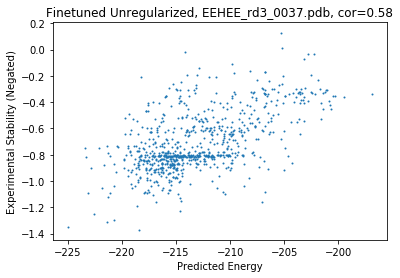

EEHEE_rd3_1498
0.43541105705495886


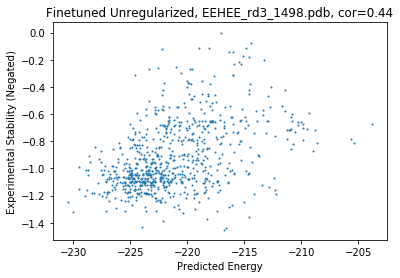

EEHEE_rd3_1702
0.22003718023015048


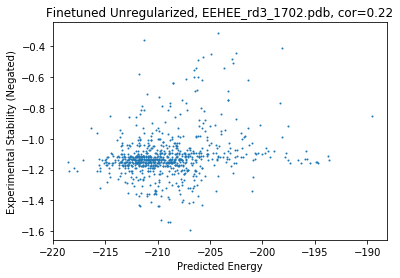

EEHEE_rd3_1716
0.5924985582870901


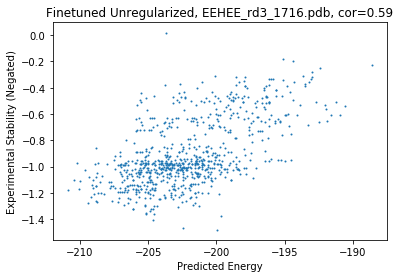

EHEE_rd1_0882
0.5659933959733698


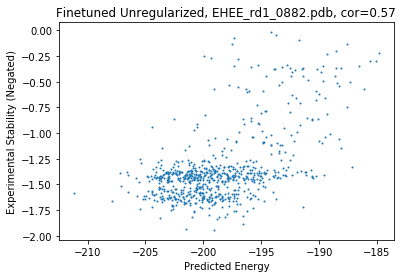

EHEE_rd2_0005
0.5553587383281317


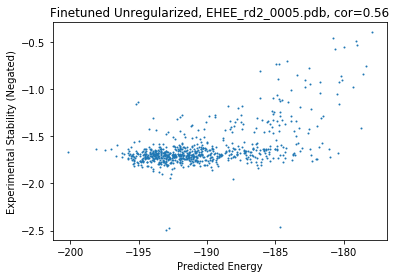

EHEE_rd3_0015
0.39358392198411146


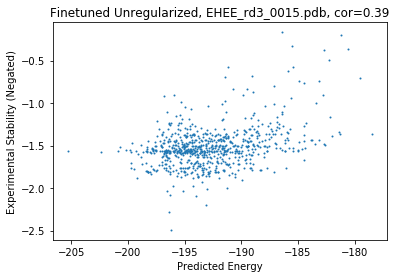

HEEH_rd2_0779
0.6901960484962532


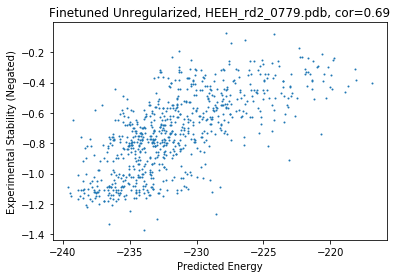

HEEH_rd3_0223
0.5600274958073329


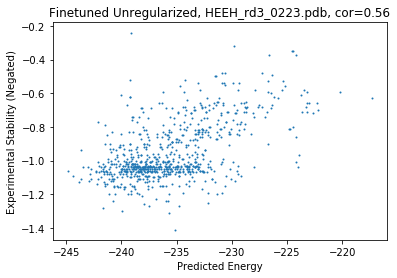

HEEH_rd3_0726
0.4111907750610147


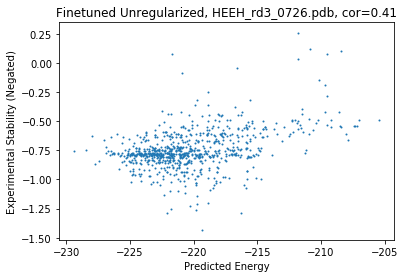

HEEH_rd3_0872
0.48609480440733566


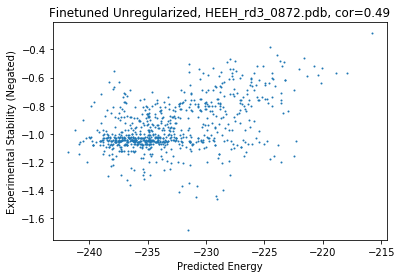

HHH_rd1_0142
0.7274636848420568


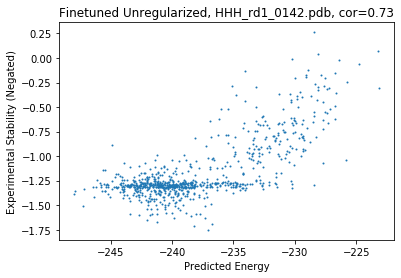

HHH_rd2_0134
0.5189548475107103


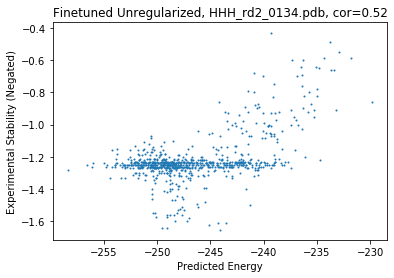

HHH_rd3_0138
0.5447218548376088


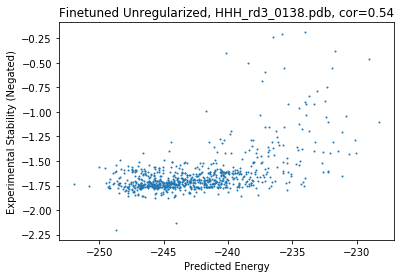

Pin1
0.6363871764285334


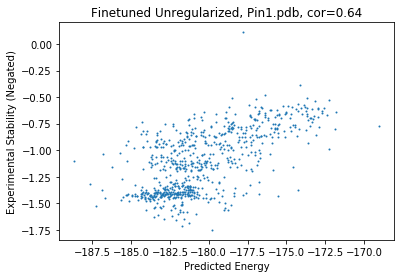

hYAP65
0.4239087446412311


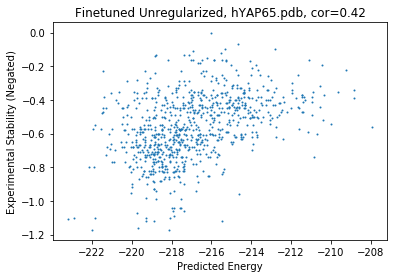

villin
0.43989490049444036


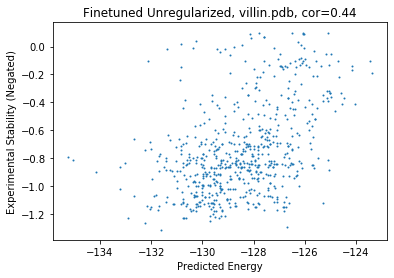

In [140]:
m = 'run_noreg_p1'
for a in all_structures:
    name = a.split('.')[0]
    table = pd.read_csv(f'../../rocklin/stability_data/{name}.csv')
    etab = np.load(f'../../rocklin_etabs/{m}/{name}.etab.npy')
    exp_energies = -1*table['consensus_stability_score']
    seqs = table['sequence']
    pred_energies = seqs.apply(lambda x: score_sequence(x, etab))
    print(name)
    cor = np.corrcoef(exp_energies, pred_energies)[0][1]
    print(cor)
    plt.figure()
    plt.scatter(pred_energies, exp_energies, s=1)
    plt.title(f"Finetuned Unregularized, {a}, cor={round(cor,2)}")
    plt.xlabel("Predicted Energy")
    plt.ylabel("Experimental Stability (Negated)")
    plt.show()

In [120]:
cors['protein'] = all_structures

In [130]:
df = pd.DataFrame(cors)
# df.set_index('protein', inplace=True)

In [131]:
df

,multi_tic_reg_0,run_noreg,run_noreg_p1,run_noreg_p4,run_noreg_p5,multi_tic_reg_1,run_original,run_permute1,run_permute4,run_permute5,protein
0,0.544008,0.399681,0.580023,0.503209,0.488951,0.523648,0.450986,0.564011,0.476735,0.458115,EEHEE_rd3_0037.pdb
1,0.349994,0.328097,0.435411,0.444977,0.428263,0.426964,0.416220,0.524816,0.475390,0.459216,EEHEE_rd3_1498.pdb
2,0.163570,0.017784,0.220037,0.158414,0.161972,0.156797,0.130897,0.200836,0.158805,0.150039,EEHEE_rd3_1702.pdb
3,0.513704,0.387793,0.592499,0.543032,0.541523,0.438483,0.415418,0.533943,0.435223,0.417672,EEHEE_rd3_1716.pdb
4,0.551279,0.427233,0.565993,0.530897,0.537696,0.400745,0.428367,0.429197,0.441488,0.384849,EHEE_rd1_0882.pdb
5,0.451927,0.366175,0.555359,0.466139,0.456016,0.338246,0.270957,0.391363,0.350331,0.293369,EHEE_rd2_0005.pdb
6,0.372335,0.271019,0.393584,0.384907,0.389707,0.324001,0.285764,0.324553,0.259166,0.197478,EHEE_rd3_0015.pdb
7,0.610167,0.559085,0.690196,0.639572,0.622300,0.546641,0.572812,0.615499,0.567334,0.525421,HEEH_rd2_0779.pdb
8,0.464345,0.407154,0.560027,0.493264,0.470889,0.377691,0.349997,0.420628,0.359381,0.358712,HEEH_rd3_0223.pdb
9,0.236101,0.293146,0.411191,0.379100,0.370614,0.238387,0.368164,0.408519,0.312397,0.287051,HEEH_rd3_0726.pdb


In [132]:
df.mean()

multi_tic_reg_0    0.436641
run_noreg          0.362549
run_noreg_p1       0.516573
run_noreg_p4       0.461676
run_noreg_p5       0.453075
multi_tic_reg_1    0.390719
run_original       0.397941
run_permute1       0.457770
run_permute4       0.411873
run_permute5       0.376796
dtype: float64

In [15]:
facebook_structures = ['EEHEE_rd3_0037.pdb', 'EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1716.pdb', 'HEEH_rd2_0779.pdb', 'HEEH_rd3_0223.pdb', 'HEEH_rd3_0726.pdb', 'HEEH_rd3_0872.pdb', 'HHH_rd2_0134.pdb', 'HHH_rd3_0138.pdb']

In [27]:
facebook = df.loc[df['protein'].isin(facebook_structures)]

NameError: name 'df' is not defined

In [135]:
facebook

,multi_tic_reg_0,run_noreg,run_noreg_p1,run_noreg_p4,run_noreg_p5,multi_tic_reg_1,run_original,run_permute1,run_permute4,run_permute5,protein
0,0.544008,0.399681,0.580023,0.503209,0.488951,0.523648,0.450986,0.564011,0.476735,0.458115,EEHEE_rd3_0037.pdb
1,0.349994,0.328097,0.435411,0.444977,0.428263,0.426964,0.416220,0.524816,0.475390,0.459216,EEHEE_rd3_1498.pdb
2,0.163570,0.017784,0.220037,0.158414,0.161972,0.156797,0.130897,0.200836,0.158805,0.150039,EEHEE_rd3_1702.pdb
3,0.513704,0.387793,0.592499,0.543032,0.541523,0.438483,0.415418,0.533943,0.435223,0.417672,EEHEE_rd3_1716.pdb
7,0.610167,0.559085,0.690196,0.639572,0.622300,0.546641,0.572812,0.615499,0.567334,0.525421,HEEH_rd2_0779.pdb
8,0.464345,0.407154,0.560027,0.493264,0.470889,0.377691,0.349997,0.420628,0.359381,0.358712,HEEH_rd3_0223.pdb
9,0.236101,0.293146,0.411191,0.379100,0.370614,0.238387,0.368164,0.408519,0.312397,0.287051,HEEH_rd3_0726.pdb
10,0.315910,0.280404,0.486095,0.319360,0.306905,0.266777,0.348303,0.413277,0.307097,0.287963,HEEH_rd3_0872.pdb
12,0.472996,0.344324,0.518955,0.468783,0.457132,0.415490,0.394459,0.442438,0.428485,0.404253,HHH_rd2_0134.pdb
13,0.497251,0.419190,0.544722,0.495254,0.482581,0.477040,0.508715,0.507307,0.497895,0.427680,HHH_rd3_0138.pdb


In [136]:
facebook.mean()

multi_tic_reg_0    0.416805
run_noreg          0.343666
run_noreg_p1       0.503916
run_noreg_p4       0.444496
run_noreg_p5       0.433113
multi_tic_reg_1    0.386792
run_original       0.395597
run_permute1       0.463127
run_permute4       0.401874
run_permute5       0.377612
dtype: float64

In [137]:
df.to_csv('../../rocklin/terminator_correlations.csv', index=False)

EEHEE_rd3_0037
0.5913661072373809


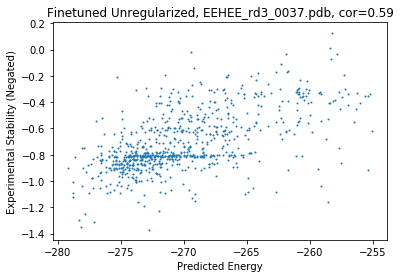

EEHEE_rd3_1498
0.3097011808592663


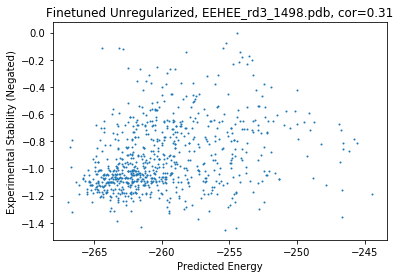

EEHEE_rd3_1702
0.15584885663068965


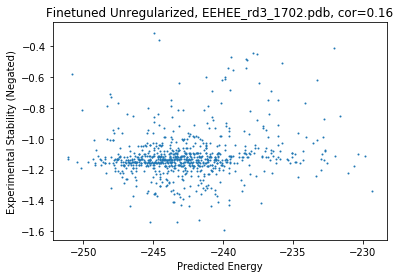

EEHEE_rd3_1716
0.42821334106916975


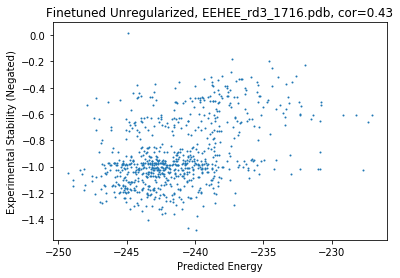

EHEE_rd1_0882
0.5374354103462851


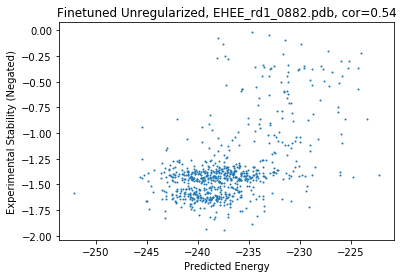

EHEE_rd2_0005
0.4224340049890016


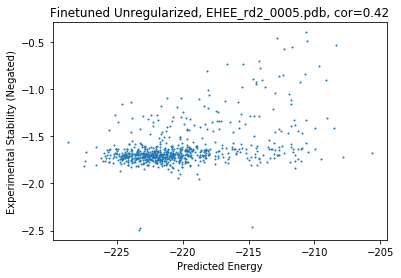

EHEE_rd3_0015
0.3607520829181433


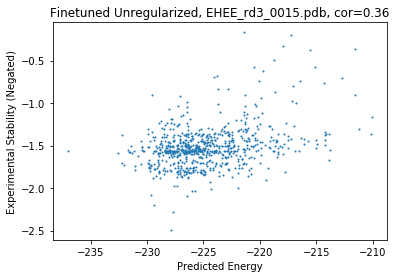

HEEH_rd2_0779
0.5480496561447928


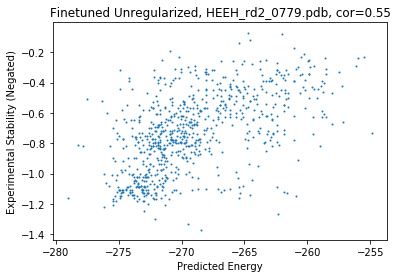

HEEH_rd3_0223
0.45732073306145965


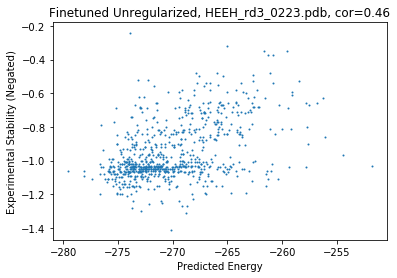

HEEH_rd3_0726
0.21598941707769487


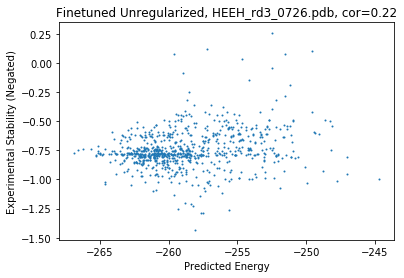

HEEH_rd3_0872
0.2955732372912182


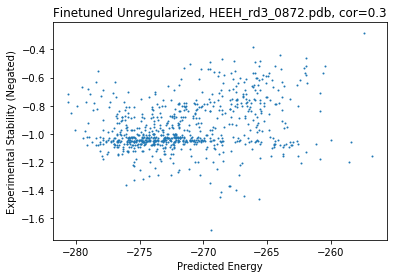

HHH_rd1_0142
0.5617523862951619


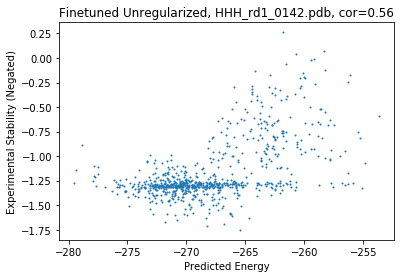

HHH_rd2_0134
0.4153401224556101


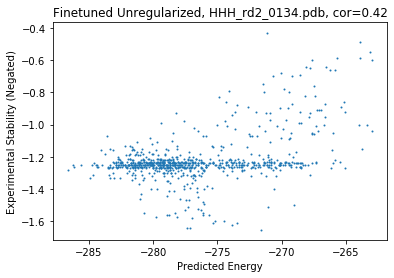

HHH_rd3_0138
0.45313066386095346


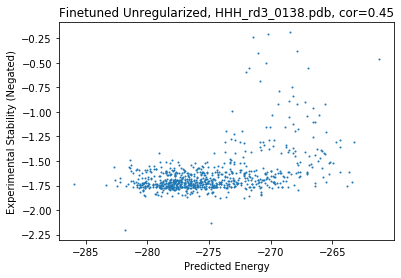

Pin1
0.5576331130268346


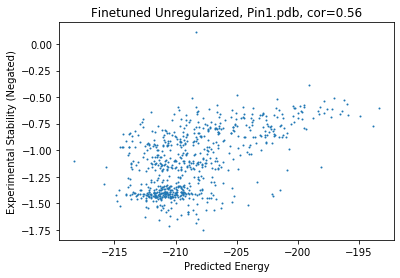

hYAP65
0.24326039639240796


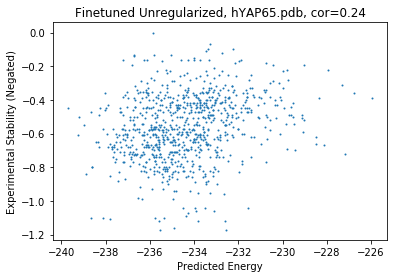

villin
0.2963194985704814


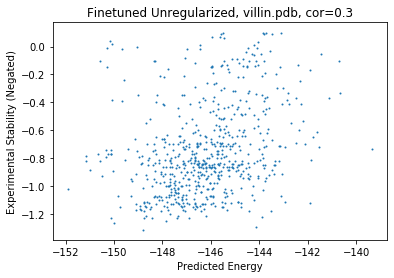

In [11]:
m = 'alexjli'
for a in all_structures:
    name = a.split('.')[0]
    table = pd.read_csv(f'../../rocklin/stability_data/{name}.csv')
    etab = np.load(f'../../rocklin_etabs/{m}/{name}.etab.npy')
    exp_energies = -1*table['consensus_stability_score']
    seqs = table['sequence']
    pred_energies = seqs.apply(lambda x: score_sequence(x, etab))
    print(name)
    cor = np.corrcoef(exp_energies, pred_energies)[0][1]
    print(cor)
    plt.figure()
    plt.scatter(pred_energies, exp_energies, s=1)
    plt.title(f"Finetuned Unregularized, {a}, cor={round(cor,2)}")
    plt.xlabel("Predicted Energy")
    plt.ylabel("Experimental Stability (Negated)")
    plt.show()

In [22]:
# models = ['multi_tic_reg_0', 'run_noreg', 'run_noreg_p1', 'run_noreg_p4', 'run_noreg_p5', 'multi_tic_reg_1', 'run_original', 'run_permute1', 'run_permute4', 'run_permute5']

for m in ['ingraham']:
    print(m)
    cors[m] = []
    for a in all_structures:
        name = a.split('.')[0]
        table = pd.read_csv(f'../../rocklin/stability_data/{name}.csv')
        etab = np.load(f'../../rocklin_etabs/{m}/{name}.etab.npy')
        exp_energies = table['consensus_stability_score']
        seqs = table['sequence']
        pred_energies = seqs.apply(lambda x: score_sequence(x, etab))
        print(name)
        cor = -1*np.corrcoef(exp_energies, pred_energies)[0][1]
        print(cor)
        cors[m].append(cor)
        # plt.figure()
        # plt.scatter(pred_energies, exp_energies, s=1)
        # plt.show()
        

ingraham
EEHEE_rd3_0037
0.6040295008901451
EEHEE_rd3_1498
0.40211309223189196
EEHEE_rd3_1702
0.22900244317605872
EEHEE_rd3_1716
0.5623748138685135
EHEE_rd1_0882
0.6151280019731842
EHEE_rd2_0005
0.43883945871454877
EHEE_rd3_0015
0.3655745833847834
HEEH_rd2_0779
0.5878275458289263
HEEH_rd3_0223
0.5295589961415539
HEEH_rd3_0726
0.26066617854531127
HEEH_rd3_0872
0.394477994521838
HHH_rd1_0142
0.688850001495904
HHH_rd2_0134
0.47800761669979064
HHH_rd3_0138
0.4929260505650062
Pin1
0.5767902692382687
hYAP65
0.40583079743680356
villin
0.45940182448291056


In [19]:
cors['protein'] = all_structures
df2 = pd.DataFrame(cors)

In [20]:
df2

,alexjli,multi_tic_reg_0,run_noreg,run_noreg_p1,run_noreg_p4,run_noreg_p5,multi_tic_reg_1,run_original,run_permute1,run_permute4,run_permute5,protein
0,0.591366,0.544008,0.399681,0.580023,0.503209,0.488951,0.523648,0.450986,0.564011,0.476735,0.458115,EEHEE_rd3_0037.pdb
1,0.309701,0.349994,0.328097,0.435411,0.444977,0.428263,0.426964,0.416220,0.524816,0.475390,0.459216,EEHEE_rd3_1498.pdb
2,0.155849,0.163570,0.017784,0.220037,0.158414,0.161972,0.156797,0.130897,0.200836,0.158805,0.150039,EEHEE_rd3_1702.pdb
3,0.428213,0.513704,0.387793,0.592499,0.543032,0.541523,0.438483,0.415418,0.533943,0.435223,0.417672,EEHEE_rd3_1716.pdb
4,0.537435,0.551279,0.427233,0.565993,0.530897,0.537696,0.400745,0.428367,0.429197,0.441488,0.384849,EHEE_rd1_0882.pdb
5,0.422434,0.451927,0.366175,0.555359,0.466139,0.456016,0.338246,0.270957,0.391363,0.350331,0.293369,EHEE_rd2_0005.pdb
6,0.360752,0.372335,0.271019,0.393584,0.384907,0.389707,0.324001,0.285764,0.324553,0.259166,0.197478,EHEE_rd3_0015.pdb
7,0.548050,0.610167,0.559085,0.690196,0.639572,0.622300,0.546641,0.572812,0.615499,0.567334,0.525421,HEEH_rd2_0779.pdb
8,0.457321,0.464345,0.407154,0.560027,0.493264,0.470889,0.377691,0.349997,0.420628,0.359381,0.358712,HEEH_rd3_0223.pdb
9,0.215989,0.236101,0.293146,0.411191,0.379100,0.370614,0.238387,0.368164,0.408519,0.312397,0.287051,HEEH_rd3_0726.pdb


In [21]:
df2.mean()

alexjli            0.402948
multi_tic_reg_0    0.436641
run_noreg          0.362549
run_noreg_p1       0.516573
run_noreg_p4       0.461676
run_noreg_p5       0.453075
multi_tic_reg_1    0.390719
run_original       0.397941
run_permute1       0.457770
run_permute4       0.411873
run_permute5       0.376796
dtype: float64

In [23]:
df2['ingraham'] = cors['ingraham']

In [24]:
df2

,alexjli,multi_tic_reg_0,run_noreg,run_noreg_p1,run_noreg_p4,run_noreg_p5,multi_tic_reg_1,run_original,run_permute1,run_permute4,run_permute5,protein,ingraham
0,0.591366,0.544008,0.399681,0.580023,0.503209,0.488951,0.523648,0.450986,0.564011,0.476735,0.458115,EEHEE_rd3_0037.pdb,0.604030
1,0.309701,0.349994,0.328097,0.435411,0.444977,0.428263,0.426964,0.416220,0.524816,0.475390,0.459216,EEHEE_rd3_1498.pdb,0.402113
2,0.155849,0.163570,0.017784,0.220037,0.158414,0.161972,0.156797,0.130897,0.200836,0.158805,0.150039,EEHEE_rd3_1702.pdb,0.229002
3,0.428213,0.513704,0.387793,0.592499,0.543032,0.541523,0.438483,0.415418,0.533943,0.435223,0.417672,EEHEE_rd3_1716.pdb,0.562375
4,0.537435,0.551279,0.427233,0.565993,0.530897,0.537696,0.400745,0.428367,0.429197,0.441488,0.384849,EHEE_rd1_0882.pdb,0.615128
5,0.422434,0.451927,0.366175,0.555359,0.466139,0.456016,0.338246,0.270957,0.391363,0.350331,0.293369,EHEE_rd2_0005.pdb,0.438839
6,0.360752,0.372335,0.271019,0.393584,0.384907,0.389707,0.324001,0.285764,0.324553,0.259166,0.197478,EHEE_rd3_0015.pdb,0.365575
7,0.548050,0.610167,0.559085,0.690196,0.639572,0.622300,0.546641,0.572812,0.615499,0.567334,0.525421,HEEH_rd2_0779.pdb,0.587828
8,0.457321,0.464345,0.407154,0.560027,0.493264,0.470889,0.377691,0.349997,0.420628,0.359381,0.358712,HEEH_rd3_0223.pdb,0.529559
9,0.215989,0.236101,0.293146,0.411191,0.379100,0.370614,0.238387,0.368164,0.408519,0.312397,0.287051,HEEH_rd3_0726.pdb,0.260666


In [25]:
df2.mean()

alexjli            0.402948
multi_tic_reg_0    0.436641
run_noreg          0.362549
run_noreg_p1       0.516573
run_noreg_p4       0.461676
run_noreg_p5       0.453075
multi_tic_reg_1    0.390719
run_original       0.397941
run_permute1       0.457770
run_permute4       0.411873
run_permute5       0.376796
ingraham           0.475965
dtype: float64

In [28]:
facebook = df2.loc[df2['protein'].isin(facebook_structures)]

In [30]:
facebook

,alexjli,multi_tic_reg_0,run_noreg,run_noreg_p1,run_noreg_p4,run_noreg_p5,multi_tic_reg_1,run_original,run_permute1,run_permute4,run_permute5,protein,ingraham
0,0.591366,0.544008,0.399681,0.580023,0.503209,0.488951,0.523648,0.450986,0.564011,0.476735,0.458115,EEHEE_rd3_0037.pdb,0.604030
1,0.309701,0.349994,0.328097,0.435411,0.444977,0.428263,0.426964,0.416220,0.524816,0.475390,0.459216,EEHEE_rd3_1498.pdb,0.402113
2,0.155849,0.163570,0.017784,0.220037,0.158414,0.161972,0.156797,0.130897,0.200836,0.158805,0.150039,EEHEE_rd3_1702.pdb,0.229002
3,0.428213,0.513704,0.387793,0.592499,0.543032,0.541523,0.438483,0.415418,0.533943,0.435223,0.417672,EEHEE_rd3_1716.pdb,0.562375
7,0.548050,0.610167,0.559085,0.690196,0.639572,0.622300,0.546641,0.572812,0.615499,0.567334,0.525421,HEEH_rd2_0779.pdb,0.587828
8,0.457321,0.464345,0.407154,0.560027,0.493264,0.470889,0.377691,0.349997,0.420628,0.359381,0.358712,HEEH_rd3_0223.pdb,0.529559
9,0.215989,0.236101,0.293146,0.411191,0.379100,0.370614,0.238387,0.368164,0.408519,0.312397,0.287051,HEEH_rd3_0726.pdb,0.260666
10,0.295573,0.315910,0.280404,0.486095,0.319360,0.306905,0.266777,0.348303,0.413277,0.307097,0.287963,HEEH_rd3_0872.pdb,0.394478
12,0.415340,0.472996,0.344324,0.518955,0.468783,0.457132,0.415490,0.394459,0.442438,0.428485,0.404253,HHH_rd2_0134.pdb,0.478008
13,0.453131,0.497251,0.419190,0.544722,0.495254,0.482581,0.477040,0.508715,0.507307,0.497895,0.427680,HHH_rd3_0138.pdb,0.492926


In [29]:
facebook.mean()

alexjli            0.387053
multi_tic_reg_0    0.416805
run_noreg          0.343666
run_noreg_p1       0.503916
run_noreg_p4       0.444496
run_noreg_p5       0.433113
multi_tic_reg_1    0.386792
run_original       0.395597
run_permute1       0.463127
run_permute4       0.401874
run_permute5       0.377612
ingraham           0.454098
dtype: float64

In [10]:
models = ['multi_noreg_p0', 'multi_noreg_p1', 'multi_reg_p0', 'multi_reg_p1', 'single_noreg_p0', 'single_noreg_p1']

cors = {}
cors['protein'] = all_structures

for m in models:
    print(m)
    cors[m] = []
    for a in all_structures:
        name = a.split('.')[0]
        table = pd.read_csv(f'../../rocklin/stability_data/{name}.csv')
        etab = np.load(f'../../rocklin_etabs/only/only_{m}/{name}.etab.npy')
        exp_energies = table['consensus_stability_score']
        seqs = table['sequence']
        pred_energies = seqs.apply(lambda x: score_sequence(x, etab))
        print(name)
        cor = -1*np.corrcoef(exp_energies, pred_energies)[0][1]
        print(cor)
        cors[m].append(cor)
        # plt.figure()
        # plt.scatter(pred_energies, exp_energies, s=1)
        # plt.show()

multi_noreg_p0
EEHEE_rd3_0037
0.6045952569953099
EEHEE_rd3_1498
0.4723063881620709
EEHEE_rd3_1702
0.18191194380882805
EEHEE_rd3_1716
0.6152878371200962
EHEE_rd1_0882
0.5674830226656704
EHEE_rd2_0005
0.5481863791864648
EHEE_rd3_0015
0.38819992258318425
HEEH_rd2_0779
0.7023089015750906
HEEH_rd3_0223
0.5630994162252775
HEEH_rd3_0726
0.546854610506079
HEEH_rd3_0872
0.6055935076688198
HHH_rd1_0142
0.7041040336360479
HHH_rd2_0134
0.5008253788208273
HHH_rd3_0138
0.5235835465148353
Pin1
0.5696589073741416
hYAP65
0.3828406815525718
villin
0.4886018815534662
multi_noreg_p1
EEHEE_rd3_0037
0.6090343109077424
EEHEE_rd3_1498
0.4747942975089296
EEHEE_rd3_1702
0.2429652886155811
EEHEE_rd3_1716
0.6455868196632526
EHEE_rd1_0882
0.5969116321551874
EHEE_rd2_0005
0.5782520189357067
EHEE_rd3_0015
0.39183968324071233
HEEH_rd2_0779
0.714030677122508
HEEH_rd3_0223
0.5821479435250703
HEEH_rd3_0726
0.5079984671588443
HEEH_rd3_0872
0.5837876794959994
HHH_rd1_0142
0.7377690790233352
HHH_rd2_0134
0.541977770161806


In [11]:
df = pd.DataFrame(cors)

In [19]:
pd.set_option('precision', 2)
df

,protein,multi_noreg_p0,multi_noreg_p1,multi_reg_p0,multi_reg_p1,single_noreg_p0,single_noreg_p1
0,EEHEE_rd3_0037.pdb,0.60,0.61,0.53,0.58,0.65,0.70
1,EEHEE_rd3_1498.pdb,0.47,0.47,0.49,0.54,0.58,0.59
2,EEHEE_rd3_1702.pdb,0.18,0.24,0.15,0.21,0.28,0.31
3,EEHEE_rd3_1716.pdb,0.62,0.65,0.52,0.57,0.63,0.67
4,EHEE_rd1_0882.pdb,0.57,0.60,0.50,0.45,0.62,0.63
5,EHEE_rd2_0005.pdb,0.55,0.58,0.32,0.40,0.53,0.57
6,EHEE_rd3_0015.pdb,0.39,0.39,0.33,0.32,0.40,0.42
7,HEEH_rd2_0779.pdb,0.70,0.71,0.56,0.62,0.71,0.71
8,HEEH_rd3_0223.pdb,0.56,0.58,0.36,0.42,0.57,0.64
9,HEEH_rd3_0726.pdb,0.55,0.51,0.43,0.45,0.60,0.62


In [13]:
df.mean()

multi_noreg_p0     0.527379
multi_noreg_p1     0.548506
multi_reg_p0       0.431617
multi_reg_p1       0.469553
single_noreg_p0    0.542240
single_noreg_p1    0.583647
dtype: float64

EEHEE_rd3_0037
0.7034556317416362


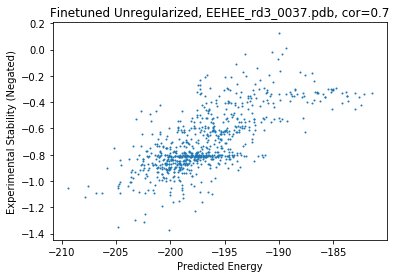

EEHEE_rd3_1498
0.5868707980106364


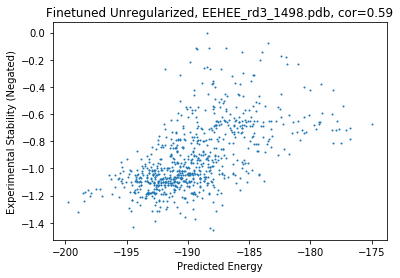

EEHEE_rd3_1702
0.314942632652979


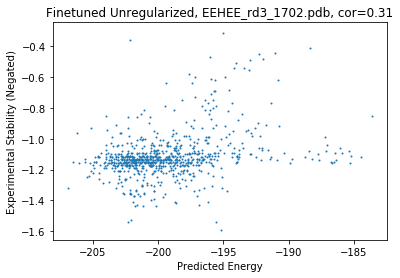

EEHEE_rd3_1716
0.6672074134462103


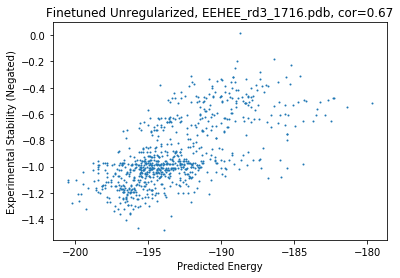

EHEE_rd1_0882
0.6267919741472525


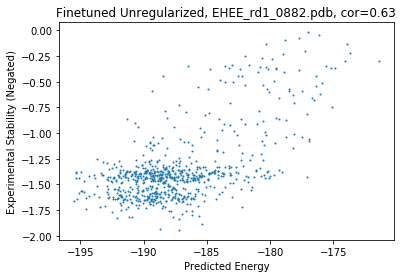

EHEE_rd2_0005
0.5690259052619209


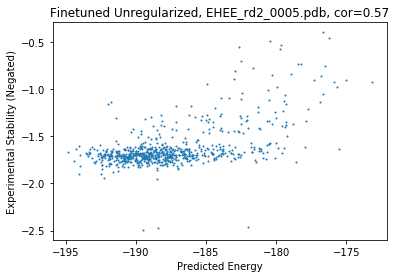

EHEE_rd3_0015
0.4199667421697206


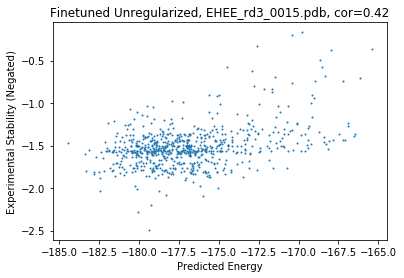

HEEH_rd2_0779
0.710450152847942


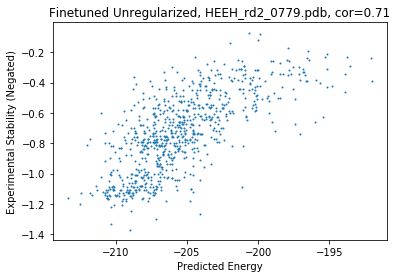

HEEH_rd3_0223
0.6360721288324899


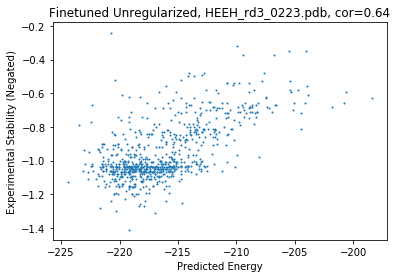

HEEH_rd3_0726
0.6211661633903716


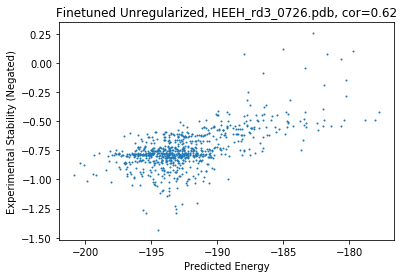

HEEH_rd3_0872
0.6727660683676593


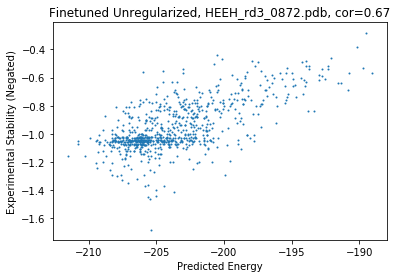

HHH_rd1_0142
0.7345454377420338


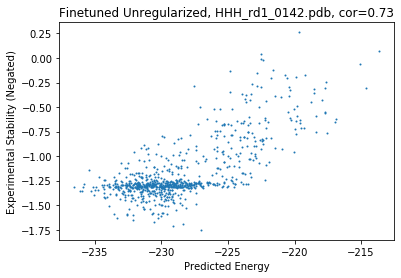

HHH_rd2_0134
0.5574092217982185


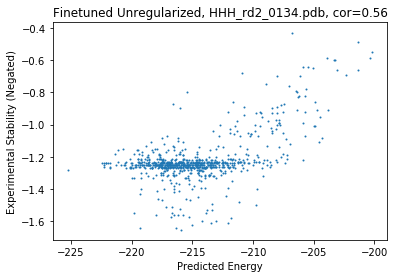

HHH_rd3_0138
0.5286848286657813


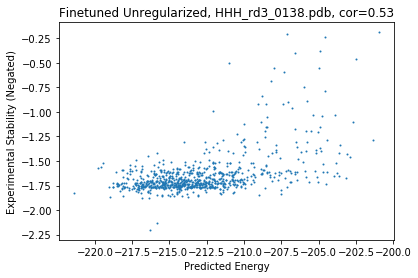

Pin1
0.6344182598113164


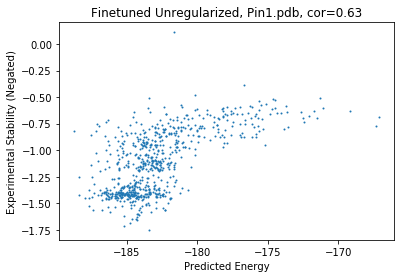

hYAP65
0.46518164151958596


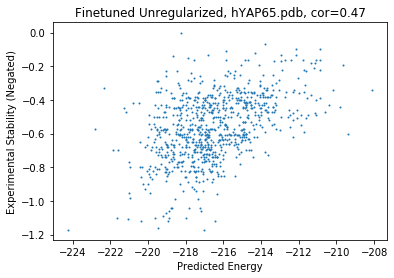

villin
0.47305247790392085


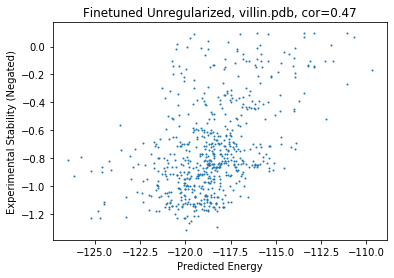

In [14]:
m = 'single_noreg_p1'
for a in all_structures:
    name = a.split('.')[0]
    table = pd.read_csv(f'../../rocklin/stability_data/{name}.csv')
    etab = np.load(f'../../rocklin_etabs/only/only_{m}/{name}.etab.npy')
    exp_energies = -1*table['consensus_stability_score']
    seqs = table['sequence']
    pred_energies = seqs.apply(lambda x: score_sequence(x, etab))
    print(name)
    cor = np.corrcoef(exp_energies, pred_energies)[0][1]
    print(cor)
    plt.figure()
    plt.scatter(pred_energies, exp_energies, s=1)
    plt.title(f"Finetuned Unregularized, {a}, cor={round(cor,2)}")
    plt.xlabel("Predicted Energy")
    plt.ylabel("Experimental Stability (Negated)")
    plt.show()

In [16]:
facebook = df.loc[df['protein'].isin(facebook_structures)]

In [17]:
facebook

,protein,multi_noreg_p0,multi_noreg_p1,multi_reg_p0,multi_reg_p1,single_noreg_p0,single_noreg_p1
0,EEHEE_rd3_0037.pdb,0.604595,0.609034,0.532926,0.584582,0.653700,0.703456
1,EEHEE_rd3_1498.pdb,0.472306,0.474794,0.492054,0.541942,0.580199,0.586871
2,EEHEE_rd3_1702.pdb,0.181912,0.242965,0.152927,0.214160,0.278467,0.314943
3,EEHEE_rd3_1716.pdb,0.615288,0.645587,0.521076,0.567197,0.626088,0.667207
7,HEEH_rd2_0779.pdb,0.702309,0.714031,0.563303,0.619880,0.710504,0.710450
8,HEEH_rd3_0223.pdb,0.563099,0.582148,0.364248,0.415916,0.573376,0.636072
9,HEEH_rd3_0726.pdb,0.546855,0.507998,0.433266,0.451989,0.604960,0.621166
10,HEEH_rd3_0872.pdb,0.605594,0.583788,0.450099,0.462672,0.656567,0.672766
12,HHH_rd2_0134.pdb,0.500825,0.541978,0.393554,0.437480,0.483232,0.557409
13,HHH_rd3_0138.pdb,0.523584,0.561910,0.465168,0.510397,0.420482,0.528685


In [18]:
facebook.mean()

multi_noreg_p0     0.531637
multi_noreg_p1     0.546423
multi_reg_p0       0.436862
multi_reg_p1       0.480622
single_noreg_p0    0.558757
single_noreg_p1    0.599903
dtype: float64

In [1]:
m = 'ingraham'
for a in all_structures:
    name = a.split('.')[0]
    table = pd.read_csv(f'../../rocklin/stability_data/{name}.csv')
    etab = np.load(f'../../rocklin_etabs/{m}/{name}.etab.npy')
    exp_energies = -1*table['consensus_stability_score']
    seqs = table['sequence']
    pred_energies = seqs.apply(lambda x: score_sequence(x, etab))
    print(name)
    cor = np.corrcoef(exp_energies, pred_energies)[0][1]
    print(cor)
    plt.figure()
    plt.scatter(pred_energies, exp_energies, s=1)
    plt.title(f"Unregularized, {a}, cor={round(cor,2)}")
    plt.xlabel("Predicted Energy")
    plt.ylabel("Experimental Stability (Negated)")
    plt.show()

NameError: name 'all_structures' is not defined

In [11]:
all_structures = ['EEHEE_rd3_0037.pdb', 'EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1716.pdb', 'EHEE_rd1_0882.pdb', 'EHEE_rd2_0005.pdb', 'EHEE_rd3_0015.pdb', 'HEEH_rd2_0779.pdb', 'HEEH_rd3_0223.pdb', 'HEEH_rd3_0726.pdb', 'HEEH_rd3_0872.pdb', 'HHH_rd1_0142.pdb', 'HHH_rd2_0134.pdb', 'HHH_rd3_0138.pdb', 'Pin1.pdb', 'hYAP65.pdb', 'villin.pdb']
all_eval_cors = {}
all_eval_cors['protein'] = all_structures

models = ['term_m', 'term_s', 'coord_m', 'coord_s', 'f_term_m', 'f_term_s', 'f_coord_s_reg']
runs = ['run0', 'run1', 'run2']
for m in models:
    for r in runs:
        mr = f"{m}/{r}"
        print(mr)
        all_eval_cors[mr] = []
        for a in all_structures:
            name = a.split('.')[0]
            table = pd.read_csv(f'../../rocklin/stability_data/{name}.csv')
            etab = np.load(f'../../rocklin/eval/terminator_eval/{m}/{r}/etabs/{name}.etab.npy')
            exp_energies = -1*table['consensus_stability_score']
            seqs = table['sequence']
            pred_energies = seqs.apply(lambda x: score_sequence(x, etab))
            # print(name)
            cor = np.corrcoef(exp_energies, pred_energies)[0][1]
            all_eval_cors[mr].append(cor)
            # print(cor)
            # plt.figure()
            # plt.scatter(pred_energies, exp_energies, s=1)
            # plt.title(f"Finetuned Unregularized, {a}, cor={round(cor,2)}")
            # plt.xlabel("Predicted Energy")
            # plt.ylabel("Experimental Stability (Negated)")
            # plt.show()
        print(all_eval_cors[mr])

term_m/run0
[0.5464034438404246, 0.31726048719709127, 0.20373869463922215, 0.48096249661652224, 0.5675515466632728, 0.4224464727138367, 0.34259680434422746, 0.48294480682921037, 0.4139418606688679, 0.18176064871910075, 0.27413610152066614, 0.5896332964637645, 0.41922896112851754, 0.4835745664130517, 0.5088393942113786, 0.3966604902730522, 0.2406433942070768]
term_m/run1
[0.5282997148873996, 0.34737871291126726, 0.1915083198230247, 0.5273791539015623, 0.5528060674713775, 0.44483244277845696, 0.3543582914242645, 0.5192160687962749, 0.4907670253037497, 0.26482240778979876, 0.2975104732569712, 0.6416177632535377, 0.45936952587111957, 0.45354219750471625, 0.5464747359371966, 0.3798860856080371, 0.29506437084714715]
term_m/run2
[0.565600125657767, 0.3505698252042107, 0.22718965583048545, 0.5082041453071175, 0.5640622447478656, 0.44676321196175317, 0.39286542416847436, 0.5292357441874616, 0.42821162093943277, 0.18502772846663382, 0.25101187361690064, 0.609715528836447, 0.43421973104258743, 0.

In [12]:
all_eval_df = pd.DataFrame(all_eval_cors)

In [13]:
all_eval_df

,protein,term_m/run0,term_m/run1,term_m/run2,term_s/run0,term_s/run1,term_s/run2,coord_m/run0,coord_m/run1,coord_m/run2,...,coord_s/run2,f_term_m/run0,f_term_m/run1,f_term_m/run2,f_term_s/run0,f_term_s/run1,f_term_s/run2,f_coord_s_reg/run0,f_coord_s_reg/run1,f_coord_s_reg/run2
0,EEHEE_rd3_0037.pdb,0.546403,0.528300,0.565600,0.598584,0.564405,0.541123,0.572192,0.568393,0.560896,...,0.614770,0.659384,0.663241,0.654959,0.689926,0.695485,0.693806,0.646731,0.643991,0.644245
1,EEHEE_rd3_1498.pdb,0.317260,0.347379,0.350570,0.409441,0.405332,0.337141,0.355530,0.318700,0.334175,...,0.375765,0.539365,0.546267,0.538995,0.581977,0.591751,0.587747,0.533066,0.532229,0.533839
2,EEHEE_rd3_1702.pdb,0.203739,0.191508,0.227190,0.291569,0.250622,0.238935,0.185526,0.199870,0.189807,...,0.261417,0.304292,0.302511,0.292195,0.330408,0.333241,0.320406,0.249228,0.239097,0.240170
3,EEHEE_rd3_1716.pdb,0.480962,0.527379,0.508204,0.532677,0.560555,0.532918,0.465049,0.485379,0.500254,...,0.532456,0.644445,0.635672,0.619539,0.692318,0.687474,0.691215,0.630606,0.630823,0.627363
4,EHEE_rd1_0882.pdb,0.567552,0.552806,0.564062,0.609870,0.628113,0.582342,0.520984,0.553713,0.571036,...,0.597336,0.609705,0.612837,0.601495,0.639726,0.635524,0.636775,0.593683,0.591218,0.595906
5,EHEE_rd2_0005.pdb,0.422446,0.444832,0.446763,0.451505,0.461449,0.381822,0.460260,0.447879,0.450228,...,0.478803,0.538472,0.541263,0.543856,0.551667,0.561666,0.557180,0.462206,0.456455,0.455553
6,EHEE_rd3_0015.pdb,0.342597,0.354358,0.392865,0.409755,0.409534,0.328014,0.365754,0.338547,0.386057,...,0.399935,0.394420,0.402889,0.394190,0.416733,0.423107,0.429514,0.360980,0.361599,0.362774
7,HEEH_rd2_0779.pdb,0.482945,0.519216,0.529236,0.572241,0.576845,0.580523,0.555651,0.570396,0.572344,...,0.563436,0.662997,0.660605,0.656494,0.694047,0.692988,0.684522,0.676351,0.681848,0.683270
8,HEEH_rd3_0223.pdb,0.413942,0.490767,0.428212,0.470812,0.477509,0.468785,0.460377,0.445531,0.462141,...,0.506924,0.614540,0.610296,0.602035,0.628538,0.624393,0.618019,0.508387,0.517179,0.519347
9,HEEH_rd3_0726.pdb,0.181761,0.264822,0.185028,0.191753,0.255840,0.220778,0.188230,0.222582,0.171730,...,0.200668,0.558540,0.567221,0.566254,0.592107,0.596271,0.593813,0.474541,0.475627,0.472065


In [14]:
all_eval_df.mean()

/home/gridsan/mlu/.conda/envs/terminator/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


term_m/run0           0.404254
term_m/run1           0.429108
term_m/run2           0.420324
term_s/run0           0.460731
term_s/run1           0.461245
term_s/run2           0.436642
coord_m/run0          0.421876
coord_m/run1          0.418442
coord_m/run2          0.409733
coord_s/run0          0.475965
coord_s/run1          0.446276
coord_s/run2          0.459404
f_term_m/run0         0.559683
f_term_m/run1         0.558592
f_term_m/run2         0.553480
f_term_s/run0         0.569106
f_term_s/run1         0.568399
f_term_s/run2         0.570132
f_coord_s_reg/run0    0.506125
f_coord_s_reg/run1    0.505410
f_coord_s_reg/run2    0.507724
dtype: float64

In [16]:
all_facebook = all_eval_df.loc[all_eval_df['protein'].isin(facebook_structures)]

In [17]:
all_facebook.mean()

/home/gridsan/mlu/.conda/envs/terminator/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


term_m/run0           0.380395
term_m/run1           0.407979
term_m/run2           0.389297
term_s/run0           0.434426
term_s/run1           0.438912
term_s/run2           0.413143
coord_m/run0          0.397016
coord_m/run1          0.399887
coord_m/run2          0.395159
coord_s/run0          0.454098
coord_s/run1          0.427947
coord_s/run2          0.435656
f_term_m/run0         0.571510
f_term_m/run1         0.571405
f_term_m/run2         0.565050
f_term_s/run0         0.579502
f_term_s/run1         0.578417
f_term_s/run2         0.578408
f_coord_s_reg/run0    0.518775
f_coord_s_reg/run1    0.518282
f_coord_s_reg/run2    0.519741
dtype: float64

In [19]:
all_structures = ['EEHEE_rd3_0037.pdb', 'EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1716.pdb', 'EHEE_rd1_0882.pdb', 'EHEE_rd2_0005.pdb', 'EHEE_rd3_0015.pdb', 'HEEH_rd2_0779.pdb', 'HEEH_rd3_0223.pdb', 'HEEH_rd3_0726.pdb', 'HEEH_rd3_0872.pdb', 'HHH_rd1_0142.pdb', 'HHH_rd2_0134.pdb', 'HHH_rd3_0138.pdb', 'Pin1.pdb', 'hYAP65.pdb', 'villin.pdb']
finetune_cors = {}
finetune_cors['protein'] = all_structures

models = ['termm', 'terms', 'coordm', 'coords']
runs = ['run0', 'run1', 'run2']
for m in models:
    for r in runs:
        mr = f"{m}/{r}"
        print(mr)
        finetune_cors[mr] = []
        for a in all_structures:
            name = a.split('.')[0]
            table = pd.read_csv(f'../../rocklin/stability_data/{name}.csv')
            etab = np.load(f'../../rocklin/eval/terminator_eval/triplicate/{m}/{r}/etabs/{name}.etab.npy')
            exp_energies = -1*table['consensus_stability_score']
            seqs = table['sequence']
            pred_energies = seqs.apply(lambda x: score_sequence(x, etab))
            # print(name)
            cor = np.corrcoef(exp_energies, pred_energies)[0][1]
            finetune_cors[mr].append(cor)
            # print(cor)
            # plt.figure()
            # plt.scatter(pred_energies, exp_energies, s=1)
            # plt.title(f"Finetuned Unregularized, {a}, cor={round(cor,2)}")
            # plt.xlabel("Predicted Energy")
            # plt.ylabel("Experimental Stability (Negated)")
            # plt.show()
        print(finetune_cors[mr])

termm/run0
[0.6655256973450456, 0.5472453222490522, 0.30299710474126124, 0.6393437542478916, 0.6162751810576789, 0.5502599091615392, 0.40584778206276323, 0.6609271453976109, 0.6118208741191701, 0.558634187465548, 0.6284022651861265, 0.7397454971624444, 0.5424045611492923, 0.5806990905964429, 0.5548384940390432, 0.4962902163194176, 0.4690765000960683]
termm/run1
[0.6793409339442361, 0.5487035745104532, 0.28794720126297146, 0.6627225721585968, 0.6443519278673047, 0.6122049475953291, 0.4492197958442873, 0.6887156193647694, 0.6290794351246901, 0.5920283404458537, 0.6499935821584735, 0.7330800754572486, 0.5810599655290889, 0.557583949054184, 0.543569547171948, 0.4630447324809981, 0.528058739395577]
termm/run2
[0.710658754988946, 0.5519462316620156, 0.3107618890550318, 0.6532667125200041, 0.6528098189044544, 0.5916340156147074, 0.4267959854908146, 0.6733595812943481, 0.6194933095908246, 0.5359079798859039, 0.5901387448628852, 0.7342167152823937, 0.5482638287027622, 0.5517048416041427, 0.5106

In [21]:
finetune_df = pd.DataFrame(finetune_cors)

In [22]:
finetune_df

,protein,termm/run0,termm/run1,termm/run2,terms/run0,terms/run1,terms/run2,coordm/run0,coordm/run1,coordm/run2,coords/run0,coords/run1,coords/run2
0,EEHEE_rd3_0037.pdb,0.665526,0.679341,0.710659,0.692957,0.689458,0.697060,0.633067,0.670313,0.668571,0.704241,0.672682,0.692061
1,EEHEE_rd3_1498.pdb,0.547245,0.548704,0.551946,0.581677,0.601241,0.628943,0.515231,0.529442,0.531664,0.577449,0.548348,0.583702
2,EEHEE_rd3_1702.pdb,0.302997,0.287947,0.310762,0.330859,0.325135,0.291403,0.275111,0.296260,0.305448,0.305438,0.273796,0.305918
3,EEHEE_rd3_1716.pdb,0.639344,0.662723,0.653267,0.692118,0.689686,0.672456,0.618594,0.660272,0.616865,0.657358,0.716120,0.667954
4,EHEE_rd1_0882.pdb,0.616275,0.644352,0.652810,0.634628,0.618889,0.635950,0.588338,0.626045,0.614823,0.630751,0.657136,0.635290
5,EHEE_rd2_0005.pdb,0.550260,0.612205,0.591634,0.554524,0.582671,0.547534,0.552258,0.566230,0.546556,0.570942,0.553050,0.578712
6,EHEE_rd3_0015.pdb,0.405848,0.449220,0.426796,0.424346,0.471301,0.393334,0.389221,0.373120,0.441113,0.419537,0.379370,0.420759
7,HEEH_rd2_0779.pdb,0.660927,0.688716,0.673360,0.689453,0.695745,0.685220,0.681893,0.714098,0.686135,0.720582,0.704521,0.703624
8,HEEH_rd3_0223.pdb,0.611821,0.629079,0.619493,0.629950,0.625591,0.584429,0.605565,0.606950,0.591264,0.632579,0.608406,0.591689
9,HEEH_rd3_0726.pdb,0.558634,0.592028,0.535908,0.588575,0.577437,0.620734,0.495066,0.548543,0.473087,0.622520,0.533922,0.539369


In [23]:
finetune_df.mean()

/home/gridsan/mlu/.conda/envs/terminator/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


termm/run0     0.562961
termm/run1     0.579453
termm/run2     0.569525
terms/run0     0.571528
terms/run1     0.582234
terms/run2     0.564643
coordm/run0    0.539324
coordm/run1    0.552887
coordm/run2    0.533697
coords/run0    0.581891
coords/run1    0.566353
coords/run2    0.561021
dtype: float64

In [9]:
# redo with averages, finetuning
all_structures = ['EEHEE_rd3_0037.pdb', 'EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1716.pdb', 'EHEE_rd1_0882.pdb', 'EHEE_rd2_0005.pdb', 'EHEE_rd3_0015.pdb', 'HEEH_rd2_0779.pdb', 'HEEH_rd3_0223.pdb', 'HEEH_rd3_0726.pdb', 'HEEH_rd3_0872.pdb', 'HHH_rd1_0142.pdb', 'HHH_rd2_0134.pdb', 'HHH_rd3_0138.pdb', 'Pin1.pdb', 'hYAP65.pdb', 'villin.pdb']
eval_cors = {}
all_eval_cors = {}
all_eval_cors['protein'] = all_structures

models = ['termm', 'terms', 'coordm', 'coords']
runs = ['run0', 'run1', 'run2']
for m in models:
    eval_cors[m] = [[0, 0, 0] for _ in range(len(all_structures))]
    for j in range(len(runs)):
        r = runs[j]
        mr = f"{m}/{r}"
        print(mr)
        for i in range(len(all_structures)):
            a = all_structures[i]
            name = a.split('.')[0]
            table = pd.read_csv(f'../../rocklin/stability_data/{name}.csv')
            etab = np.load(f'../../rocklin/eval/terminator_eval/triplicate/{m}/{r}/etabs/{name}.etab.npy')
            exp_energies = -1*table['consensus_stability_score']
            seqs = table['sequence']
            pred_energies = seqs.apply(lambda x: score_sequence(x, etab))
            # print(name)
            cor = np.corrcoef(exp_energies, pred_energies)[0][1]
            eval_cors[m][i][j] = cor
            # print(cor)
            # plt.figure()
            # plt.scatter(pred_energies, exp_energies, s=1)
            # plt.title(f"Finetuned Unregularized, {a}, cor={round(cor,2)}")
            # plt.xlabel("Predicted Energy")
            # plt.ylabel("Experimental Stability (Negated)")
            # plt.show()
    
    means = [np.mean(x) for x in eval_cors[m]]
    stds = [np.std(x) for x in eval_cors[m]]
    print(eval_cors[m])
    print(means)
    print(stds)
    all_eval_cors[m+"_means"] = means
    all_eval_cors[m+"_stds"] = stds

termm/run0
termm/run1
termm/run2
[[0.6655256973450456, 0.6793409339442361, 0.710658754988946], [0.5472453222490522, 0.5487035745104532, 0.5519462316620156], [0.30299710474126124, 0.28794720126297146, 0.3107618890550318], [0.6393437542478916, 0.6627225721585968, 0.6532667125200041], [0.6162751810576789, 0.6443519278673047, 0.6528098189044544], [0.5502599091615392, 0.6122049475953291, 0.5916340156147074], [0.40584778206276323, 0.4492197958442873, 0.4267959854908146], [0.6609271453976109, 0.6887156193647694, 0.6733595812943481], [0.6118208741191701, 0.6290794351246901, 0.6194933095908246], [0.558634187465548, 0.5920283404458537, 0.5359079798859039], [0.6284022651861265, 0.6499935821584735, 0.5901387448628852], [0.7397454971624444, 0.7330800754572486, 0.7342167152823937], [0.5424045611492923, 0.5810599655290889, 0.5482638287027622], [0.5806990905964429, 0.557583949054184, 0.5517048416041427], [0.5548384940390432, 0.543569547171948, 0.5106082678137175], [0.4962902163194176, 0.46304473248099

In [10]:
df = pd.DataFrame(all_eval_cors)

In [11]:
df

,protein,termm_means,termm_stds,terms_means,terms_stds,coordm_means,coordm_stds,coords_means,coords_stds
0,EEHEE_rd3_0037.pdb,0.685175,0.018882,0.693159,0.003107,0.657317,0.017162,0.689661,0.012995
1,EEHEE_rd3_1498.pdb,0.549298,0.001965,0.603954,0.019392,0.525446,0.007279,0.569833,0.015405
2,EEHEE_rd3_1702.pdb,0.300569,0.009471,0.315799,0.017408,0.292273,0.012702,0.295051,0.015031
3,EEHEE_rd3_1716.pdb,0.651778,0.009602,0.684753,0.008752,0.631910,0.020067,0.680478,0.025572
4,EHEE_rd1_0882.pdb,0.637812,0.015616,0.629822,0.007750,0.609735,0.015808,0.641059,0.011518
5,EHEE_rd2_0005.pdb,0.584700,0.025760,0.561576,0.015187,0.555015,0.008265,0.567568,0.010745
6,EHEE_rd3_0015.pdb,0.427288,0.017710,0.429660,0.032051,0.401151,0.029012,0.406555,0.019229
7,HEEH_rd2_0779.pdb,0.674334,0.011366,0.690139,0.004324,0.694042,0.014287,0.709576,0.007791
8,HEEH_rd3_0223.pdb,0.620131,0.007060,0.613323,0.020509,0.601260,0.007090,0.610891,0.016785
9,HEEH_rd3_0726.pdb,0.562190,0.023049,0.595582,0.018357,0.505565,0.031687,0.565270,0.040543


In [12]:
df.mean()

termm_means     0.570646
termm_stds      0.015532
terms_means     0.572802
terms_stds      0.015665
coordm_means    0.541969
coordm_stds     0.022865
coords_means    0.569755
coords_stds     0.018327
dtype: float64

In [13]:
df.std()

termm_means     0.104530
termm_stds      0.008353
terms_means     0.106893
terms_stds      0.007456
coordm_means    0.110770
coordm_stds     0.025189
coords_means    0.114594
coords_stds     0.008263
dtype: float64

In [6]:
# redo with averages, baseline models
all_structures = ['EEHEE_rd3_0037.pdb', 'EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1716.pdb', 'EHEE_rd1_0882.pdb', 'EHEE_rd2_0005.pdb', 'EHEE_rd3_0015.pdb', 'HEEH_rd2_0779.pdb', 'HEEH_rd3_0223.pdb', 'HEEH_rd3_0726.pdb', 'HEEH_rd3_0872.pdb', 'HHH_rd1_0142.pdb', 'HHH_rd2_0134.pdb', 'HHH_rd3_0138.pdb', 'Pin1.pdb', 'hYAP65.pdb', 'villin.pdb']
eval_cors = {}
all_eval_cors = {}
all_eval_cors['protein'] = all_structures

models = ['term_m', 'term_s', 'coord_m', 'coord_s']
runs = ['run0', 'run1', 'run2']
for m in models:
    eval_cors[m] = [[0, 0, 0] for _ in range(len(all_structures))]
    for j in range(len(runs)):
        r = runs[j]
        mr = f"{m}/{r}"
        print(mr)
        for i in range(len(all_structures)):
            a = all_structures[i]
            name = a.split('.')[0]
            table = pd.read_csv(f'../../rocklin/stability_data/{name}.csv')
            etab = np.load(f'../../rocklin/eval/terminator_eval/{m}/{r}/etabs/{name}.etab.npy')
            exp_energies = -1*table['consensus_stability_score']
            seqs = table['sequence']
            pred_energies = seqs.apply(lambda x: score_sequence(x, etab))
            # print(name)
            cor = np.corrcoef(exp_energies, pred_energies)[0][1]
            eval_cors[m][i][j] = cor
            # print(cor)
            # plt.figure()
            # plt.scatter(pred_energies, exp_energies, s=1)
            # plt.title(f"Finetuned Unregularized, {a}, cor={round(cor,2)}")
            # plt.xlabel("Predicted Energy")
            # plt.ylabel("Experimental Stability (Negated)")
            # plt.show()
    
    means = [np.mean(x) for x in eval_cors[m]]
    stds = [np.std(x) for x in eval_cors[m]]
    print(eval_cors[m])
    print(means)
    print(stds)
    all_eval_cors[m+"_means"] = means
    all_eval_cors[m+"_stds"] = stds

term_m/run0
term_m/run1
term_m/run2
[[0.5464034438404246, 0.5282997148873996, 0.565600125657767], [0.31726048719709127, 0.34737871291126726, 0.3505698252042107], [0.20373869463922215, 0.1915083198230247, 0.22718965583048545], [0.48096249661652224, 0.5273791539015623, 0.5082041453071175], [0.5675515466632728, 0.5528060674713775, 0.5640622447478656], [0.4224464727138367, 0.44483244277845696, 0.44676321196175317], [0.34259680434422746, 0.3543582914242645, 0.39286542416847436], [0.48294480682921037, 0.5192160687962749, 0.5292357441874616], [0.4139418606688679, 0.4907670253037497, 0.42821162093943277], [0.18176064871910075, 0.26482240778979876, 0.18502772846663382], [0.27413610152066614, 0.2975104732569712, 0.25101187361690064], [0.5896332964637645, 0.6416177632535377, 0.609715528836447], [0.41922896112851754, 0.45936952587111957, 0.43421973104258743], [0.4835745664130517, 0.45354219750471625, 0.41370451500826794], [0.5088393942113786, 0.5464747359371966, 0.5073243688833327], [0.39666049027

In [7]:
# redo with averages, regularized models
models = ['termm', 'terms', 'coordm', 'coords']
runs = ['run0', 'run1', 'run2']
for m in models:
    eval_cors[m] = [[0, 0, 0] for _ in range(len(all_structures))]
    for j in range(len(runs)):
        r = runs[j]
        mr = f"{m}/{r}"
        print(mr)
        for i in range(len(all_structures)):
            a = all_structures[i]
            name = a.split('.')[0]
            table = pd.read_csv(f'../../rocklin/stability_data/{name}.csv')
            etab = np.load(f'../../rocklin/eval/terminator_eval/{m}_reg/{r}/etabs/{name}.etab.npy')
            exp_energies = -1*table['consensus_stability_score']
            seqs = table['sequence']
            pred_energies = seqs.apply(lambda x: score_sequence(x, etab))
            # print(name)
            cor = np.corrcoef(exp_energies, pred_energies)[0][1]
            eval_cors[m][i][j] = cor
            # print(cor)
            # plt.figure()
            # plt.scatter(pred_energies, exp_energies, s=1)
            # plt.title(f"Finetuned Unregularized, {a}, cor={round(cor,2)}")
            # plt.xlabel("Predicted Energy")
            # plt.ylabel("Experimental Stability (Negated)")
            # plt.show()
    
    means = [np.mean(x) for x in eval_cors[m]]
    stds = [np.std(x) for x in eval_cors[m]]
#     print(eval_cors[m])
#     print(means)
#     print(stds)
    all_eval_cors[m+"_means"] = means
    all_eval_cors[m+"_stds"] = stds

termm/run0
termm/run1
termm/run2
terms/run0
terms/run1
terms/run2
coordm/run0
coordm/run1
coordm/run2
coords/run0
coords/run1
coords/run2


In [8]:
# redo with averages, finetuning
models = ['termm', 'terms', 'coordm', 'coords']
runs = ['run0', 'run1', 'run2']
for m in models:
    eval_cors[m] = [[0, 0, 0] for _ in range(len(all_structures))]
    for j in range(len(runs)):
        r = runs[j]
        mr = f"{m}/{r}"
        print(mr)
        for i in range(len(all_structures)):
            a = all_structures[i]
            name = a.split('.')[0]
            table = pd.read_csv(f'../../rocklin/stability_data/{name}.csv')
            etab = np.load(f'../../rocklin/eval/terminator_eval/triplicate/{m}/{r}/etabs/{name}.etab.npy')
            exp_energies = -1*table['consensus_stability_score']
            seqs = table['sequence']
            pred_energies = seqs.apply(lambda x: score_sequence(x, etab))
            # print(name)
            cor = np.corrcoef(exp_energies, pred_energies)[0][1]
            eval_cors[m][i][j] = cor
            # print(cor)
            # plt.figure()
            # plt.scatter(pred_energies, exp_energies, s=1)
            # plt.title(f"Finetuned Unregularized, {a}, cor={round(cor,2)}")
            # plt.xlabel("Predicted Energy")
            # plt.ylabel("Experimental Stability (Negated)")
            # plt.show()
    
    means = [np.mean(x) for x in eval_cors[m]]
    stds = [np.std(x) for x in eval_cors[m]]
#     print(eval_cors[m])
#     print(means)
#     print(stds)
    all_eval_cors[m+"_finetune_means"] = means
    all_eval_cors[m+"_finetune_stds"] = stds

termm/run0
termm/run1
termm/run2
terms/run0
terms/run1
terms/run2
coordm/run0
coordm/run1
coordm/run2
coords/run0
coords/run1
coords/run2


In [15]:
from scipy.stats import ttest_rel

print(all_eval_cors["term_s_means"])
print(np.mean(all_eval_cors["term_s_means"]))
print(all_eval_cors["terms_means"])
print(np.mean(all_eval_cors["terms_means"]))
print(ttest_rel(all_eval_cors["term_s_means"], all_eval_cors["terms_means"]))
print(ttest_rel(all_eval_cors["coord_s_means"], all_eval_cors["coords_means"]))

[0.5680374739684967, 0.38397149049226464, 0.2603753260361392, 0.5420498979627224, 0.606774735870647, 0.4315918521593389, 0.3824347305594376, 0.5765361822626701, 0.47236861646645334, 0.22279020388478554, 0.33060260428957605, 0.6456711359979218, 0.44705653304840304, 0.4844800112687264, 0.5600753896210883, 0.44911164568239587, 0.3349137323350609]
0.4528730330533017
[0.538732785226656, 0.39303956848203364, 0.22858029950403524, 0.4731170151253958, 0.4784044691882621, 0.3477394141549833, 0.3283807351619969, 0.5539801945794192, 0.4096600104256653, 0.25380563568961284, 0.32519250255210447, 0.5909553631597643, 0.41008419037877686, 0.4455344693247012, 0.5157365742696857, 0.4368405105995156, 0.29503456846061027]
0.413224606251954
Ttest_relResult(statistic=4.466991318027316, pvalue=0.00038923871542292536)
Ttest_relResult(statistic=5.2319200991597015, pvalue=8.223301987943749e-05)


In [16]:
df = pd.DataFrame(all_eval_cors)

In [17]:
df.to_csv("rocklin_cor_results.csv")

In [20]:
import pickle
with open('rocklin_cor_results.pkl', 'wb') as f:
    pickle.dump(all_eval_cors, f)

In [18]:
print(ttest_rel(all_eval_cors["term_s_means"], all_eval_cors["coord_s_means"]))
print(ttest_rel(all_eval_cors["term_m_means"], all_eval_cors["coord_m_means"]))

Ttest_relResult(statistic=-1.2808247005875384, pvalue=0.21851052307778068)
Ttest_relResult(statistic=0.18201903437774758, pvalue=0.857853889876978)


In [19]:
print(ttest_rel(all_eval_cors["term_s_means"], all_eval_cors["term_m_means"]))
print(ttest_rel(all_eval_cors["coord_s_means"], all_eval_cors["coord_m_means"]))

Ttest_relResult(statistic=7.41208600373122, pvalue=1.4712547877624997e-06)
Ttest_relResult(statistic=4.567451772129664, pvalue=0.00031627651055214894)


In [3]:
all_eval_cors = pd.read_pickle('rocklin_cor_results.pkl')

In [7]:
all_eval_cors.keys()

dict_keys(['protein', 'term_m_means', 'term_m_stds', 'term_s_means', 'term_s_stds', 'coord_m_means', 'coord_m_stds', 'coord_s_means', 'coord_s_stds', 'termm_means', 'termm_stds', 'terms_means', 'terms_stds', 'coordm_means', 'coordm_stds', 'coords_means', 'coords_stds', 'termm_finetune_means', 'termm_finetune_stds', 'terms_finetune_means', 'terms_finetune_stds', 'coordm_finetune_means', 'coordm_finetune_stds', 'coords_finetune_means', 'coords_finetune_stds'])

In [11]:
df = pd.read_csv('rocklin_cor_results.csv')

In [15]:
print(ttest_rel(all_eval_cors["term_s_means"], all_eval_cors["terms_finetune_means"]))
print(ttest_rel(all_eval_cors["term_m_means"], all_eval_cors["termm_finetune_means"]))
print(ttest_rel(all_eval_cors["coord_s_means"], all_eval_cors["coords_finetune_means"]))
print(ttest_rel(all_eval_cors["coord_m_means"], all_eval_cors["coordm_finetune_means"]))


Ttest_relResult(statistic=-4.544073985084362, pvalue=0.0003319022003909217)
Ttest_relResult(statistic=-6.959834642771058, pvalue=3.2148406974052716e-06)
Ttest_relResult(statistic=-4.968276654000265, pvalue=0.0001395225762860081)
Ttest_relResult(statistic=-7.200713104117293, pvalue=2.11282848038349e-06)


In [21]:
df.keys()

Index(['Unnamed: 0', 'protein', 'term_m_means', 'term_m_stds', 'term_s_means',
       'term_s_stds', 'coord_m_means', 'coord_m_stds', 'coord_s_means',
       'coord_s_stds', 'termm_means', 'termm_stds', 'terms_means',
       'terms_stds', 'coordm_means', 'coordm_stds', 'coords_means',
       'coords_stds', 'termm_finetune_means', 'termm_finetune_stds',
       'terms_finetune_means', 'terms_finetune_stds', 'coordm_finetune_means',
       'coordm_finetune_stds', 'coords_finetune_means',
       'coords_finetune_stds'],
      dtype='object')

In [22]:
df[['protein','term_s_means', 'terms_finetune_means', 'coord_s_means', 'coords_finetune_means']]

,protein,term_s_means,terms_finetune_means,coord_s_means,coords_finetune_means
0,EEHEE_rd3_0037.pdb,0.568037,0.693159,0.597815,0.689661
1,EEHEE_rd3_1498.pdb,0.383971,0.603954,0.369026,0.569833
2,EEHEE_rd3_1702.pdb,0.260375,0.315799,0.232829,0.295051
3,EEHEE_rd3_1716.pdb,0.542050,0.684753,0.561755,0.680478
4,EHEE_rd1_0882.pdb,0.606775,0.629822,0.595540,0.641059
5,EHEE_rd2_0005.pdb,0.431592,0.561576,0.445392,0.567568
6,EHEE_rd3_0015.pdb,0.382435,0.429660,0.371243,0.406555
7,HEEH_rd2_0779.pdb,0.576536,0.690139,0.577976,0.709576
8,HEEH_rd3_0223.pdb,0.472369,0.613323,0.510659,0.610891
9,HEEH_rd3_0726.pdb,0.222790,0.595582,0.225583,0.565270


In [23]:
df[['protein','term_s_means', 'terms_finetune_means', 'coord_s_means', 'coords_finetune_means']].mean()

term_s_means             0.452873
terms_finetune_means     0.572802
coord_s_means            0.460548
coords_finetune_means    0.569755
dtype: float64

In [24]:
facebook_structures = ['EEHEE_rd3_0037.pdb', 'EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1716.pdb', 'HEEH_rd2_0779.pdb', 'HEEH_rd3_0223.pdb', 'HEEH_rd3_0726.pdb', 'HEEH_rd3_0872.pdb', 'HHH_rd2_0134.pdb', 'HHH_rd3_0138.pdb']
all_facebook = df.loc[df['protein'].isin(facebook_structures)]

In [25]:
all_facebook[['protein','term_s_means', 'terms_finetune_means', 'coord_s_means', 'coords_finetune_means']].mean()

term_s_means             0.428827
terms_finetune_means     0.586737
coord_s_means            0.439234
coords_finetune_means    0.583317
dtype: float64

In [15]:
df2 = pd.DataFrame(all_eval_cors)

In [16]:
df2

,protein,term_m_means,term_m_stds,term_s_means,term_s_stds,coord_m_means,coord_m_stds,coord_s_means,coord_s_stds
0,EEHEE_rd3_0037.pdb,0.546768,0.015230,0.568037,0.023599,0.567160,0.004693,0.597815,0.016960
1,EEHEE_rd3_1498.pdb,0.338403,0.015007,0.383971,0.033157,0.336135,0.015100,0.369026,0.030146
2,EEHEE_rd3_1702.pdb,0.207479,0.014805,0.260375,0.022567,0.191734,0.006013,0.232829,0.021947
3,EEHEE_rd3_1716.pdb,0.505515,0.019045,0.542050,0.013085,0.483561,0.014429,0.561755,0.023673
4,EHEE_rd1_0882.pdb,0.561473,0.006292,0.606775,0.018813,0.548578,0.020754,0.595540,0.016776
5,EHEE_rd2_0005.pdb,0.438014,0.011036,0.431592,0.035426,0.452789,0.005369,0.445392,0.025037
6,EHEE_rd3_0015.pdb,0.363274,0.021468,0.382435,0.038481,0.363453,0.019464,0.371243,0.021490
7,HEEH_rd2_0779.pdb,0.510466,0.019885,0.576536,0.003388,0.566130,0.007453,0.577976,0.010495
8,HEEH_rd3_0223.pdb,0.444307,0.033365,0.472369,0.003728,0.456016,0.007449,0.510659,0.014155
9,HEEH_rd3_0726.pdb,0.210537,0.038409,0.222790,0.026202,0.194181,0.021182,0.225583,0.025527


In [17]:
df2.mean()

term_m_means     0.417895
term_m_stds      0.020380
term_s_means     0.452873
term_s_stds      0.018464
coord_m_means    0.416684
coord_m_stds     0.017321
coord_s_means    0.460548
coord_s_stds     0.020381
dtype: float64

In [18]:
df2.std()

term_m_means     0.122147
term_m_stds      0.009941
term_s_means     0.122297
term_s_stds      0.011004
coord_m_means    0.136082
coord_m_stds     0.025085
coord_s_means    0.125884
coord_s_stds     0.009992
dtype: float64

In [17]:
facebook_structures = ['EEHEE_rd3_0037.pdb', 'EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1716.pdb', 'HEEH_rd2_0779.pdb', 'HEEH_rd3_0223.pdb', 'HEEH_rd3_0726.pdb', 'HEEH_rd3_0872.pdb', 'HHH_rd2_0134.pdb', 'HHH_rd3_0138.pdb']
all_facebook = df.loc[df['protein'].isin(facebook_structures)]

In [18]:
all_facebook.mean()

term_m_means     0.392557
term_m_stds      0.021991
term_s_means     0.428827
term_s_stds      0.016705
coord_m_means    0.397354
coord_m_stds     0.009285
coord_s_means    0.439234
coord_s_stds     0.019041
dtype: float64

In [1]:
all_facebook

NameError: name 'all_facebook' is not defined

In [19]:
# redo with averages
all_structures = ['EEHEE_rd3_0037.pdb', 'EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1716.pdb', 'EHEE_rd1_0882.pdb', 'EHEE_rd2_0005.pdb', 'EHEE_rd3_0015.pdb', 'HEEH_rd2_0779.pdb', 'HEEH_rd3_0223.pdb', 'HEEH_rd3_0726.pdb', 'HEEH_rd3_0872.pdb', 'HHH_rd1_0142.pdb', 'HHH_rd2_0134.pdb', 'HHH_rd3_0138.pdb', 'Pin1.pdb', 'hYAP65.pdb', 'villin.pdb']
# eval_cors = {}
# all_eval_cors = {}
# all_eval_cors['protein'] = all_structures

models = ['termm', 'terms', 'coordm', 'coords']
runs = ['run0', 'run1', 'run2']
for m in models:
    eval_cors[m] = [[0, 0, 0] for _ in range(len(all_structures))]
    for j in range(len(runs)):
        r = runs[j]
        mr = f"{m}/{r}"
        print(mr)
        for i in range(len(all_structures)):
            a = all_structures[i]
            name = a.split('.')[0]
            table = pd.read_csv(f'../../rocklin/stability_data/{name}.csv')
            etab = np.load(f'../../rocklin/eval/terminator_eval/{m}_reg/{r}/etabs/{name}.etab.npy')
            exp_energies = -1*table['consensus_stability_score']
            seqs = table['sequence']
            pred_energies = seqs.apply(lambda x: score_sequence(x, etab))
            # print(name)
            cor = np.corrcoef(exp_energies, pred_energies)[0][1]
            eval_cors[m][i][j] = cor
            # print(cor)
            # plt.figure()
            # plt.scatter(pred_energies, exp_energies, s=1)
            # plt.title(f"Finetuned Unregularized, {a}, cor={round(cor,2)}")
            # plt.xlabel("Predicted Energy")
            # plt.ylabel("Experimental Stability (Negated)")
            # plt.show()
    
    means = [np.mean(x) for x in eval_cors[m]]
    stds = [np.std(x) for x in eval_cors[m]]
    print(eval_cors[m])
    print(means)
    print(stds)
    all_eval_cors[m+"_means"] = means
    all_eval_cors[m+"_stds"] = stds

termm/run0
termm/run1
termm/run2
[[0.5379830317021335, 0.5290625579010033, 0.5080502741105714], [0.3583012680583147, 0.372293367435895, 0.38840978069826], [0.16386979391545273, 0.23373938735083855, 0.20145722069486968], [0.44182831699997405, 0.4767026505603624, 0.43286568022151917], [0.45581495113879594, 0.4493650331773022, 0.4378757560423291], [0.37360573977116796, 0.3357943596098846, 0.35412606153683457], [0.31313602003127655, 0.3605387401028022, 0.3133460131201616], [0.5548187718877745, 0.5352999696146185, 0.5479667797767008], [0.4178629766045351, 0.4464671356747193, 0.3915227849286778], [0.2570457977929078, 0.23848533139939135, 0.2585576227837668], [0.30385409597809615, 0.3181363444463926, 0.3225452054794104], [0.5875100355758502, 0.557277580272991, 0.5653760031159764], [0.4154883328871902, 0.38486803208979664, 0.3849632826325676], [0.49143911904277265, 0.41446127281242456, 0.41841266068011973], [0.47764209134533614, 0.5363266554359369, 0.5070912139598447], [0.5085841977488251, 0.3

In [20]:
df3 = pd.DataFrame(all_eval_cors)

In [21]:
df3

,protein,termm_means,termm_stds,terms_means,terms_stds,coordm_means,coordm_stds,coords_means,coords_stds
0,EEHEE_rd3_0037.pdb,0.525032,0.012548,0.538733,0.014296,0.527026,0.012812,0.521258,0.004746
1,EEHEE_rd3_1498.pdb,0.373001,0.012302,0.393040,0.017305,0.390080,0.005814,0.399104,0.032988
2,EEHEE_rd3_1702.pdb,0.199689,0.028552,0.228580,0.015179,0.170123,0.031475,0.213011,0.013756
3,EEHEE_rd3_1716.pdb,0.450466,0.018910,0.473117,0.026476,0.463121,0.026682,0.489821,0.020472
4,EHEE_rd1_0882.pdb,0.447685,0.007419,0.478404,0.022149,0.424066,0.017425,0.474955,0.012101
5,EHEE_rd2_0005.pdb,0.354509,0.015439,0.347739,0.005702,0.337991,0.009843,0.352556,0.004952
6,EHEE_rd3_0015.pdb,0.329007,0.022297,0.328381,0.015212,0.314875,0.001655,0.314543,0.012071
7,HEEH_rd2_0779.pdb,0.546029,0.008086,0.553980,0.026785,0.540190,0.007902,0.546480,0.019906
8,HEEH_rd3_0223.pdb,0.418618,0.022437,0.409660,0.018594,0.393359,0.012745,0.420673,0.033386
9,HEEH_rd3_0726.pdb,0.251363,0.009127,0.253806,0.012244,0.226178,0.050997,0.226181,0.012393


In [22]:
df3.mean()

termm_means     0.404225
termm_stds      0.022097
terms_means     0.413225
terms_stds      0.019860
coordm_means    0.391183
coordm_stds     0.015022
coords_means    0.404739
coords_stds     0.018254
dtype: float64

In [23]:
df3.std()

termm_means     0.101283
termm_stds      0.017625
terms_means     0.106137
terms_stds      0.011917
coordm_means    0.110976
coordm_stds     0.012374
coords_means    0.113342
coords_stds     0.013443
dtype: float64

In [10]:
# alex experiments
all_structures = ['EEHEE_rd3_0037.pdb', 'EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1716.pdb', 'EHEE_rd1_0882.pdb', 'EHEE_rd2_0005.pdb', 'EHEE_rd3_0015.pdb', 'HEEH_rd2_0779.pdb', 'HEEH_rd3_0223.pdb', 'HEEH_rd3_0726.pdb', 'HEEH_rd3_0872.pdb', 'HHH_rd1_0142.pdb', 'HHH_rd2_0134.pdb', 'HHH_rd3_0138.pdb', 'Pin1.pdb', 'hYAP65.pdb', 'villin.pdb']
all_eval_cors = {}
all_eval_cors['protein'] = all_structures

models = ['ingraham_delete_tic_nlcpl_test_run2', 'ingraham_gvp_delete_tic_nlcpl_test_run2']
for m in models:
    all_eval_cors[m] = []
    for i in range(len(all_structures)):
        a = all_structures[i]
        name = a.split('.')[0]
        table = pd.read_csv(f'../../rocklin/stability_data/{name}.csv')
        etab = np.load(f'/data1/groups/keatinglab/alexjli/refactor_dirs/data/outputs/rocklin/{m}/etabs/{name}.etab.npy')
        exp_energies = -1*table['consensus_stability_score']
        seqs = table['sequence']
        pred_energies = seqs.apply(lambda x: score_sequence(x, etab))
        # print(name)
        cor = np.corrcoef(exp_energies, pred_energies)[0][1]
        all_eval_cors[m].append(cor)


In [12]:
df = pd.DataFrame(all_eval_cors)

In [13]:
df

,protein,ingraham_delete_tic_nlcpl_test_run2,ingraham_gvp_delete_tic_nlcpl_test_run2
0,EEHEE_rd3_0037.pdb,0.590703,0.605031
1,EEHEE_rd3_1498.pdb,0.346305,0.317808
2,EEHEE_rd3_1702.pdb,0.230919,0.249299
3,EEHEE_rd3_1716.pdb,0.575178,0.574640
4,EHEE_rd1_0882.pdb,0.591987,0.591914
5,EHEE_rd2_0005.pdb,0.423500,0.427458
6,EHEE_rd3_0015.pdb,0.363318,0.375728
7,HEEH_rd2_0779.pdb,0.557176,0.543742
8,HEEH_rd3_0223.pdb,0.498232,0.461064
9,HEEH_rd3_0726.pdb,0.234843,0.188073


In [14]:
df.mean()

ingraham_delete_tic_nlcpl_test_run2        0.455962
ingraham_gvp_delete_tic_nlcpl_test_run2    0.446413
dtype: float64

In [15]:
facebook_structures = ['EEHEE_rd3_0037.pdb', 'EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1716.pdb', 'HEEH_rd2_0779.pdb', 'HEEH_rd3_0223.pdb', 'HEEH_rd3_0726.pdb', 'HEEH_rd3_0872.pdb', 'HHH_rd2_0134.pdb', 'HHH_rd3_0138.pdb']
all_facebook = df.loc[df['protein'].isin(facebook_structures)]
all_facebook.mean()

ingraham_delete_tic_nlcpl_test_run2        0.428472
ingraham_gvp_delete_tic_nlcpl_test_run2    0.421077
dtype: float64

In [8]:
# include nlcpl
all_structures = ['EEHEE_rd3_0037.pdb', 'EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1716.pdb', 'EHEE_rd1_0882.pdb', 'EHEE_rd2_0005.pdb', 'EHEE_rd3_0015.pdb', 'HEEH_rd2_0779.pdb', 'HEEH_rd3_0223.pdb', 'HEEH_rd3_0726.pdb', 'HEEH_rd3_0872.pdb', 'HHH_rd1_0142.pdb', 'HHH_rd2_0134.pdb', 'HHH_rd3_0138.pdb', 'Pin1.pdb', 'hYAP65.pdb', 'villin.pdb']
eval_cors = {}
all_eval_cors = {}
all_eval_cors['protein'] = all_structures

models = ['termm', 'terms', 'coordm', 'coords']
runs = ['run0_10', 'run1_10', 'run2_10']
for m in models:
    eval_cors[m] = [[0, 0, 0] for _ in range(len(all_structures))]
    for j in range(len(runs)):
        r = runs[j]
        mr = f"{m}/{r}"
        print(mr)
        for i in range(len(all_structures)):
            a = all_structures[i]
            name = a.split('.')[0]
            table = pd.read_csv(f'../../rocklin/stability_data/{name}.csv')
            etab = np.load(f'../../rocklin/eval/terminator_eval/include_nlcpl/{m}/{r}/etabs/{name}.etab.npy')
            exp_energies = -1*table['consensus_stability_score']
            seqs = table['sequence']
            pred_energies = seqs.apply(lambda x: score_sequence(x, etab))
            cor = np.corrcoef(exp_energies, pred_energies)[0][1]
            eval_cors[m][i][j] = cor

    means = [np.mean(x) for x in eval_cors[m]]
    stds = [np.std(x) for x in eval_cors[m]]
    print(eval_cors[m])
    print(means)
    print(stds)
    all_eval_cors[m+"_means"] = means
    all_eval_cors[m+"_stds"] = stds

termm/run0_10
termm/run1_10
termm/run2_10
[[0.5754211389415802, 0.4895132901812262, 0.45047406146770663], [0.36456784156000077, 0.37312237334217535, 0.2931571387953816], [0.2413608756956801, 0.13973690253364238, 0.11320203666361701], [0.46511986035558106, 0.4800835576964383, 0.43786193616056507], [0.5544139851117437, 0.5467974087514113, 0.48058269667835374], [0.47876964234076014, 0.45345237274921985, 0.438937412128639], [0.3884672146298378, 0.38378779011324904, 0.31427801747418604], [0.5350974380256467, 0.5352156249218664, 0.5577195754227159], [0.5242847543424716, 0.5032751897809944, 0.4698572048144063], [0.35850960159861484, 0.23642868251468838, 0.1578691261671608], [0.3486798998015792, 0.2817482043483082, 0.2126260649410085], [0.6485124744858024, 0.6214738612283214, 0.545651275894565], [0.44088197432912396, 0.41006806757964853, 0.40305657113945165], [0.5456217818799971, 0.4096260531273188, 0.3920957581788458], [0.6135769934633266, 0.5649509433440351, 0.4056506408598602], [0.427110579

In [9]:
df = pd.DataFrame(all_eval_cors)

In [10]:
df

,protein,termm_means,termm_stds,terms_means,terms_stds,coordm_means,coordm_stds,coords_means,coords_stds
0,EEHEE_rd3_0037.pdb,0.505136,0.052192,0.495488,0.049675,0.566864,0.008151,0.520892,0.011101
1,EEHEE_rd3_1498.pdb,0.343616,0.035850,0.363457,0.074658,0.403220,0.034655,0.345534,0.030114
2,EEHEE_rd3_1702.pdb,0.164767,0.055233,0.180191,0.060825,0.195145,0.033099,0.116879,0.023101
3,EEHEE_rd3_1716.pdb,0.461022,0.017479,0.476304,0.063438,0.487026,0.022032,0.454114,0.064672
4,EHEE_rd1_0882.pdb,0.527265,0.033155,0.555087,0.046125,0.544059,0.014870,0.563095,0.012316
5,EHEE_rd2_0005.pdb,0.457053,0.016460,0.406010,0.065466,0.512834,0.017438,0.448943,0.024847
6,EHEE_rd3_0015.pdb,0.362178,0.033924,0.322147,0.076723,0.358828,0.027156,0.326728,0.023100
7,HEEH_rd2_0779.pdb,0.542678,0.010636,0.591378,0.016931,0.610194,0.020861,0.594700,0.004527
8,HEEH_rd3_0223.pdb,0.499139,0.022412,0.481382,0.046697,0.509399,0.006910,0.499562,0.037452
9,HEEH_rd3_0726.pdb,0.250936,0.082551,0.270713,0.045675,0.284903,0.037109,0.271864,0.001734


In [11]:
df.mean()

termm_means     0.419521
termm_stds      0.044653
terms_means     0.414742
terms_stds      0.046835
coordm_means    0.440134
coordm_stds     0.026794
coords_means    0.422897
coords_stds     0.029170
dtype: float64

In [12]:
facebook_structures = ['EEHEE_rd3_0037.pdb', 'EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1716.pdb', 'HEEH_rd2_0779.pdb', 'HEEH_rd3_0223.pdb', 'HEEH_rd3_0726.pdb', 'HEEH_rd3_0872.pdb', 'HHH_rd2_0134.pdb', 'HHH_rd3_0138.pdb']
all_facebook = df.loc[df['protein'].isin(facebook_structures)]
all_facebook.mean()

termm_means     0.391543
termm_stds      0.041694
terms_means     0.391583
terms_stds      0.050120
coordm_means    0.422186
coordm_stds     0.023357
coords_means    0.393706
coords_stds     0.027628
dtype: float64

In [13]:
# include nlcpl
all_structures = ['EEHEE_rd3_0037.pdb', 'EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1716.pdb', 'EHEE_rd1_0882.pdb', 'EHEE_rd2_0005.pdb', 'EHEE_rd3_0015.pdb', 'HEEH_rd2_0779.pdb', 'HEEH_rd3_0223.pdb', 'HEEH_rd3_0726.pdb', 'HEEH_rd3_0872.pdb', 'HHH_rd1_0142.pdb', 'HHH_rd2_0134.pdb', 'HHH_rd3_0138.pdb', 'Pin1.pdb', 'hYAP65.pdb', 'villin.pdb']
eval_cors = {}
all_eval_cors = {}
all_eval_cors['protein'] = all_structures

models = ['termm', 'terms', 'coordm', 'coords']
runs = ['run0_100', 'run1_100', 'run2_100']
for m in models:
    eval_cors[m] = [[0, 0, 0] for _ in range(len(all_structures))]
    for j in range(len(runs)):
        r = runs[j]
        mr = f"{m}/{r}"
        print(mr)
        for i in range(len(all_structures)):
            a = all_structures[i]
            name = a.split('.')[0]
            table = pd.read_csv(f'../../rocklin/stability_data/{name}.csv')
            etab = np.load(f'../../rocklin/eval/terminator_eval/include_nlcpl/{m}/{r}/etabs/{name}.etab.npy')
            exp_energies = -1*table['consensus_stability_score']
            seqs = table['sequence']
            pred_energies = seqs.apply(lambda x: score_sequence(x, etab))
            cor = np.corrcoef(exp_energies, pred_energies)[0][1]
            eval_cors[m][i][j] = cor

    means = [np.mean(x) for x in eval_cors[m]]
    stds = [np.std(x) for x in eval_cors[m]]
    print(eval_cors[m])
    print(means)
    print(stds)
    all_eval_cors[m+"_means"] = means
    all_eval_cors[m+"_stds"] = stds

termm/run0_100
termm/run1_100
termm/run2_100
[[0.6142328891801754, 0.5851004030746842, 0.6410993899571822], [0.44196031037617844, 0.43533991221482127, 0.45848438827401494], [0.272722627751972, 0.22016123453571884, 0.26984649051464], [0.5749556988177004, 0.5927825380421146, 0.5930513809818437], [0.5897987255902679, 0.5999844715572109, 0.613903432706511], [0.5217976706214925, 0.5325587285050056, 0.5452648141117618], [0.3944453659974507, 0.42615032539259196, 0.4235915473896946], [0.5963635755433115, 0.6377606646868971, 0.6216378792396993], [0.5789860617523193, 0.581324207227256, 0.5683610957197351], [0.43539664572677617, 0.3892725603105044, 0.3388352158551529], [0.46997690317699076, 0.425596132301593, 0.4040137743965372], [0.6956125552601133, 0.6880520292958799, 0.6713428639397658], [0.4919166586382779, 0.4955447970302543, 0.4747555829520278], [0.5860934848864102, 0.5112607380178467, 0.49571594842245614], [0.606031994988804, 0.5660615665397885, 0.5276157477966005], [0.5023695597738151, 0.

In [14]:
df = pd.DataFrame(all_eval_cors)

In [15]:
df

,protein,termm_means,termm_stds,terms_means,terms_stds,coordm_means,coordm_stds,coords_means,coords_stds
0,EEHEE_rd3_0037.pdb,0.613478,0.022868,0.644802,0.007942,0.615261,0.029532,0.664376,0.009038
1,EEHEE_rd3_1498.pdb,0.445262,0.009733,0.501387,0.025404,0.441744,0.025872,0.497685,0.030636
2,EEHEE_rd3_1702.pdb,0.254243,0.024128,0.285555,0.019479,0.250330,0.014537,0.266743,0.023182
3,EEHEE_rd3_1716.pdb,0.586930,0.008468,0.625770,0.036978,0.563719,0.043098,0.636275,0.042795
4,EHEE_rd1_0882.pdb,0.601229,0.009880,0.624820,0.015181,0.566057,0.025796,0.628506,0.004919
5,EHEE_rd2_0005.pdb,0.533207,0.009591,0.508350,0.039359,0.533526,0.025277,0.532182,0.022066
6,EHEE_rd3_0015.pdb,0.414729,0.014381,0.411731,0.045138,0.381557,0.006627,0.396491,0.016902
7,HEEH_rd2_0779.pdb,0.618587,0.017037,0.677837,0.010280,0.644285,0.025106,0.689468,0.006988
8,HEEH_rd3_0223.pdb,0.576224,0.005641,0.594916,0.023776,0.558432,0.028147,0.602866,0.006546
9,HEEH_rd3_0726.pdb,0.387835,0.039434,0.427769,0.021886,0.387815,0.063903,0.439219,0.007442


In [16]:
df.mean()

termm_means     0.510902
termm_stds      0.020541
terms_means     0.531800
terms_stds      0.023704
coordm_means    0.489688
coordm_stds     0.036544
coords_means    0.543052
coords_stds     0.018725
dtype: float64

In [17]:
facebook_structures = ['EEHEE_rd3_0037.pdb', 'EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1716.pdb', 'HEEH_rd2_0779.pdb', 'HEEH_rd3_0223.pdb', 'HEEH_rd3_0726.pdb', 'HEEH_rd3_0872.pdb', 'HHH_rd2_0134.pdb', 'HHH_rd3_0138.pdb']
all_facebook = df.loc[df['protein'].isin(facebook_structures)]
all_facebook.mean()

termm_means     0.493418
termm_stds      0.020329
terms_means     0.525020
terms_stds      0.024730
coordm_means    0.482792
coordm_stds     0.033798
coords_means    0.537900
coords_stds     0.018315
dtype: float64

In [3]:
# include nlcpl
all_structures = ['EEHEE_rd3_0037.pdb', 'EEHEE_rd3_1498.pdb', 'EEHEE_rd3_1702.pdb', 'EEHEE_rd3_1716.pdb', 'EHEE_rd1_0882.pdb', 'EHEE_rd2_0005.pdb', 'EHEE_rd3_0015.pdb', 'HEEH_rd2_0779.pdb', 'HEEH_rd3_0223.pdb', 'HEEH_rd3_0726.pdb', 'HEEH_rd3_0872.pdb', 'HHH_rd1_0142.pdb', 'HHH_rd2_0134.pdb', 'HHH_rd3_0138.pdb', 'Pin1.pdb', 'hYAP65.pdb', 'villin.pdb']
eval_cors = {}
all_eval_cors = {}
all_eval_cors['protein'] = all_structures

In [4]:
all_eval_cors['termm_means'] = [0.6134775607373473, 0.44526153695500487, 0.25424345093411027, 0.5869298726138862, 0.6012288766179966, 0.53320707107942, 0.41472907959324584, 0.6185873731566359, 0.5762237882331035, 0.3878348072974778, 0.433195603291707, 0.6850024828319198, 0.48740567954018665, 0.5310233904422378, 0.5665697697750643, 0.47854216153544704, 0.4718686836778902]
all_eval_cors['terms_means'] = [0.6448015435247498, 0.5013867124129242, 0.2855551089112963, 0.625770353901109, 0.6248195300708315, 0.5083501187018413, 0.4117311012147355, 0.677836973806382, 0.5949155060375698, 0.42776861928439797, 0.5277614466416526, 0.6888725562777803, 0.46190265808842934, 0.5025050894126144, 0.6033571379054262, 0.4867952322924063, 0.4664773508300135]
all_eval_cors['coordm_means'] = [0.6152608809150965, 0.44174374551826984, 0.250330336367447, 0.5637185530300152, 0.5660572297355134, 0.5335258096673856, 0.3815573517263285, 0.6442853192162946, 0.5584318439966623, 0.38781507961168216, 0.40918530599577657, 0.6697707235779508, 0.46460404060889476, 0.4925442771938819, 0.5670900212168547, 0.39582723173128215, 0.38295144521661234]
all_eval_cors['coords_means'] = [0.6643759513068942, 0.49768507677108936, 0.26674316587700225, 0.6362746829600808, 0.6285061600681233, 0.5321820402671361, 0.39649115439805604, 0.6894676551815649, 0.6028659843038556, 0.4392185749097411, 0.5550549136854032, 0.7104896469708506, 0.5027578971497298, 0.5245602590339898, 0.6192228063172239, 0.4636123882023688, 0.5023834479419503]

In [5]:
df = pd.DataFrame(all_eval_cors)

In [6]:
df

,protein,termm_means,terms_means,coordm_means,coords_means
0,EEHEE_rd3_0037.pdb,0.613478,0.644802,0.615261,0.664376
1,EEHEE_rd3_1498.pdb,0.445262,0.501387,0.441744,0.497685
2,EEHEE_rd3_1702.pdb,0.254243,0.285555,0.250330,0.266743
3,EEHEE_rd3_1716.pdb,0.586930,0.625770,0.563719,0.636275
4,EHEE_rd1_0882.pdb,0.601229,0.624820,0.566057,0.628506
5,EHEE_rd2_0005.pdb,0.533207,0.508350,0.533526,0.532182
6,EHEE_rd3_0015.pdb,0.414729,0.411731,0.381557,0.396491
7,HEEH_rd2_0779.pdb,0.618587,0.677837,0.644285,0.689468
8,HEEH_rd3_0223.pdb,0.576224,0.594916,0.558432,0.602866
9,HEEH_rd3_0726.pdb,0.387835,0.427769,0.387815,0.439219


In [7]:
df.mean()

termm_means     0.510902
terms_means     0.531800
coordm_means    0.489688
coords_means    0.543052
dtype: float64

In [8]:
df.std()

termm_means     0.105586
terms_means     0.107459
coordm_means    0.113201
coords_means    0.114680
dtype: float64